# EMG WORD PREDICTION

### IMPORT NECESSARY MODULES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import glob
import pickle
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 300

from scipy import signal
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import librosa

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras

CURR_DIR = os.getcwd()

### NECESSARY DEFINITIONS

In [3]:

MAIN_DIR = os.path.join(CURR_DIR,"..","..")
DATA_DIR = os.path.join(MAIN_DIR,"dataset")
FIG_DIR = os.path.join(MAIN_DIR,"figures")
os.makedirs(FIG_DIR,exist_ok=True)

SPEAKER = ["RL","RN","SR","US"]
MODE = ["mentally","mouthed"]
WORDS = ["add","call","go","later","left","reply","right","stop","subtract","you"]

SAMPLING_FREQ = 250 
NUM_CHANNELS = 8


# a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIG_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## DATASET

### LOAD DATASET

In [4]:
def load_dataset(describe=True):
    """
    loads the dataset stored in pickle format
    """
    if("dataset.pickle" in os.listdir(DATA_DIR)):
        file = open(os.path.join(DATA_DIR,"dataset.pickle"),"rb")
        dataset = pickle.load(file)
        return dataset
    
    else:
        print("Dataset not found.")

dataset = load_dataset()

# making suitable dataframes
df = pd.DataFrame(dataset)
df_mentally = df[df["mode"]=="mentally"]
df_mentally = df_mentally.copy().reset_index(drop=True)
df_mouthed = df[df["mode"]=="mouthed"]
df_mouthed = df_mouthed.copy().reset_index(drop=True)

print("Dataset variable type: ",type(dataset))
print("Dataset keys: ",dataset.keys())
print("Total samples: ",len(dataset["data"]))
print("Mouthed samples: ",len(df_mouthed))
print("Mental samples: ",len(df_mentally))
print("Speakers: ",SPEAKER)
print("Words: ",WORDS)

Dataset variable type:  <class 'dict'>
Dataset keys:  dict_keys(['data', 'speaker', 'mode', 'word'])
Total samples:  5760
Mouthed samples:  2603
Mental samples:  3157
Speakers:  ['RL', 'RN', 'SR', 'US']
Words:  ['add', 'call', 'go', 'later', 'left', 'reply', 'right', 'stop', 'subtract', 'you']


In [5]:
# separate data according to the users

df_mentally_US = df_mentally[df_mentally["speaker"]=="US"] 
df_mentally_SR = df_mentally[df_mentally["speaker"]=="SR"] 
df_mentally_RL = df_mentally[df_mentally["speaker"]=="RL"] 
df_mentally_RN = df_mentally[df_mentally["speaker"]=="RN"] 

df_mouthed_US = df_mouthed[df_mouthed["speaker"]=="US"] 
df_mouthed_SR = df_mouthed[df_mouthed["speaker"]=="SR"] 
df_mouthed_RL = df_mouthed[df_mouthed["speaker"]=="RL"] 
df_mouthed_RN = df_mouthed[df_mouthed["speaker"]=="RN"] 

print(len(df_mentally_US))
print(len(df_mentally_SR))
print(len(df_mentally_RL))
print(len(df_mentally_RN))

print(len(df_mouthed_US))
print(len(df_mouthed_SR))
print(len(df_mouthed_RL))
print(len(df_mouthed_RN))


1783
276
727
371
1766
269
235
333


Saving figure data distribution by speaker


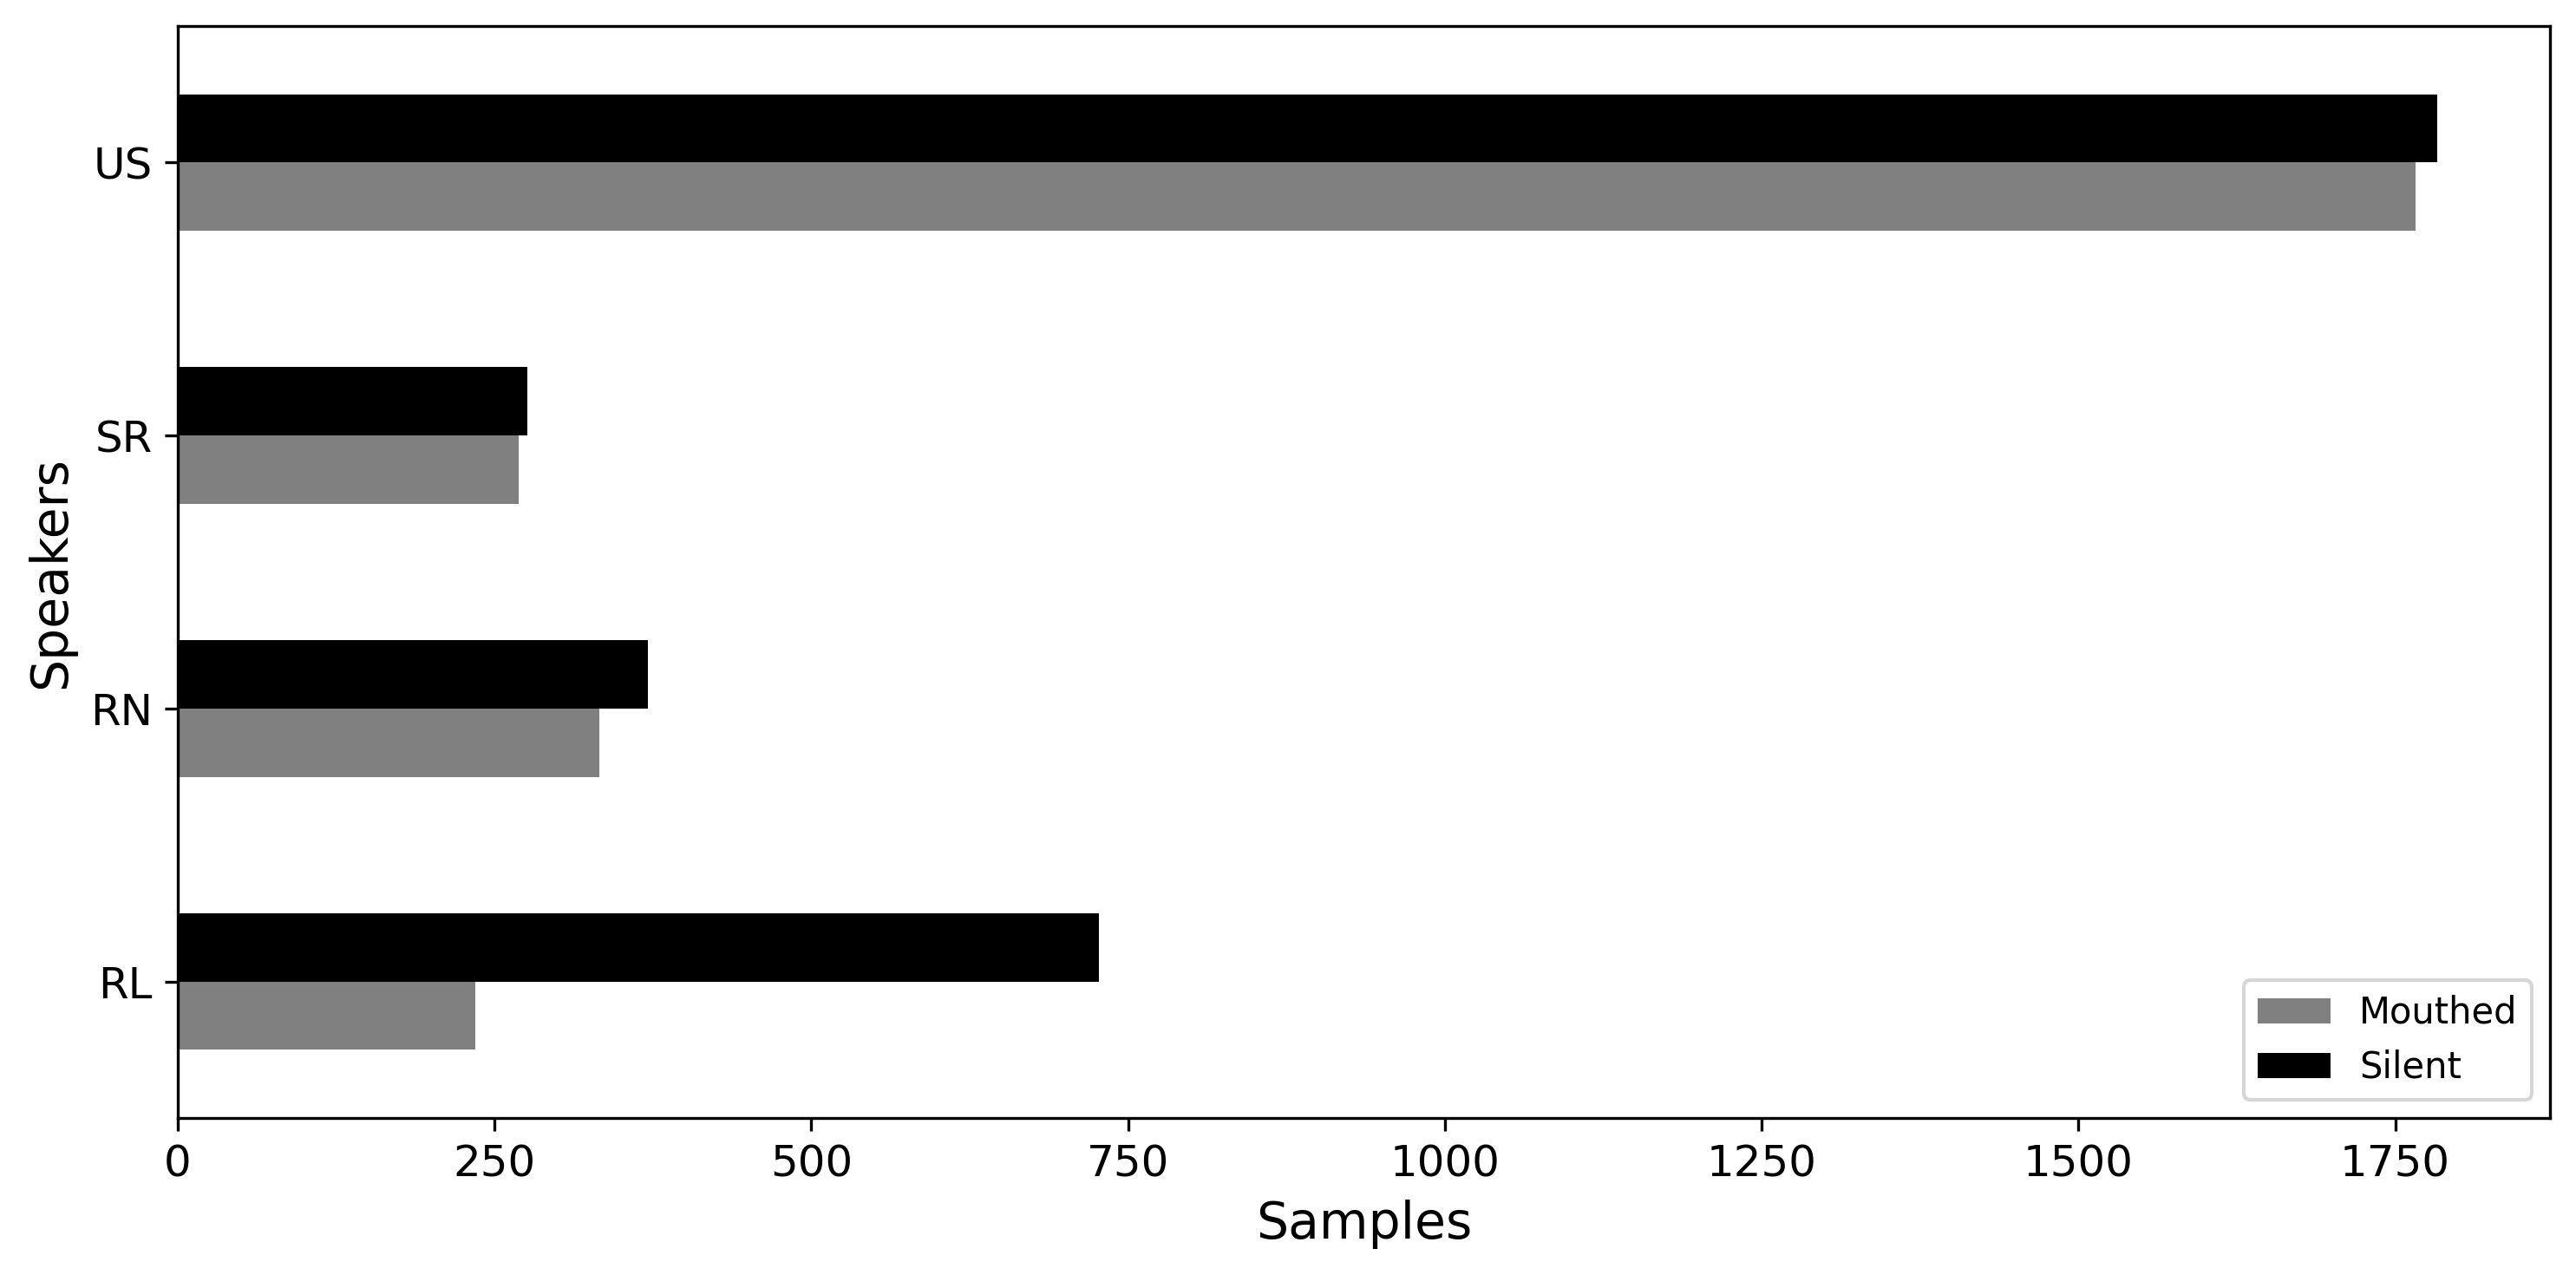

In [6]:
labels = pd.DataFrame({"Mouthed":df_mouthed["speaker"].value_counts(),
                       "Silent":df_mentally["speaker"].value_counts()})

labels.plot(kind="barh",rot=0,color={"black","gray"})
plt.xlabel("Samples")
plt.ylabel("Speakers")
# plt.axis("off")
save_fig("data distribution by speaker")
plt.show()

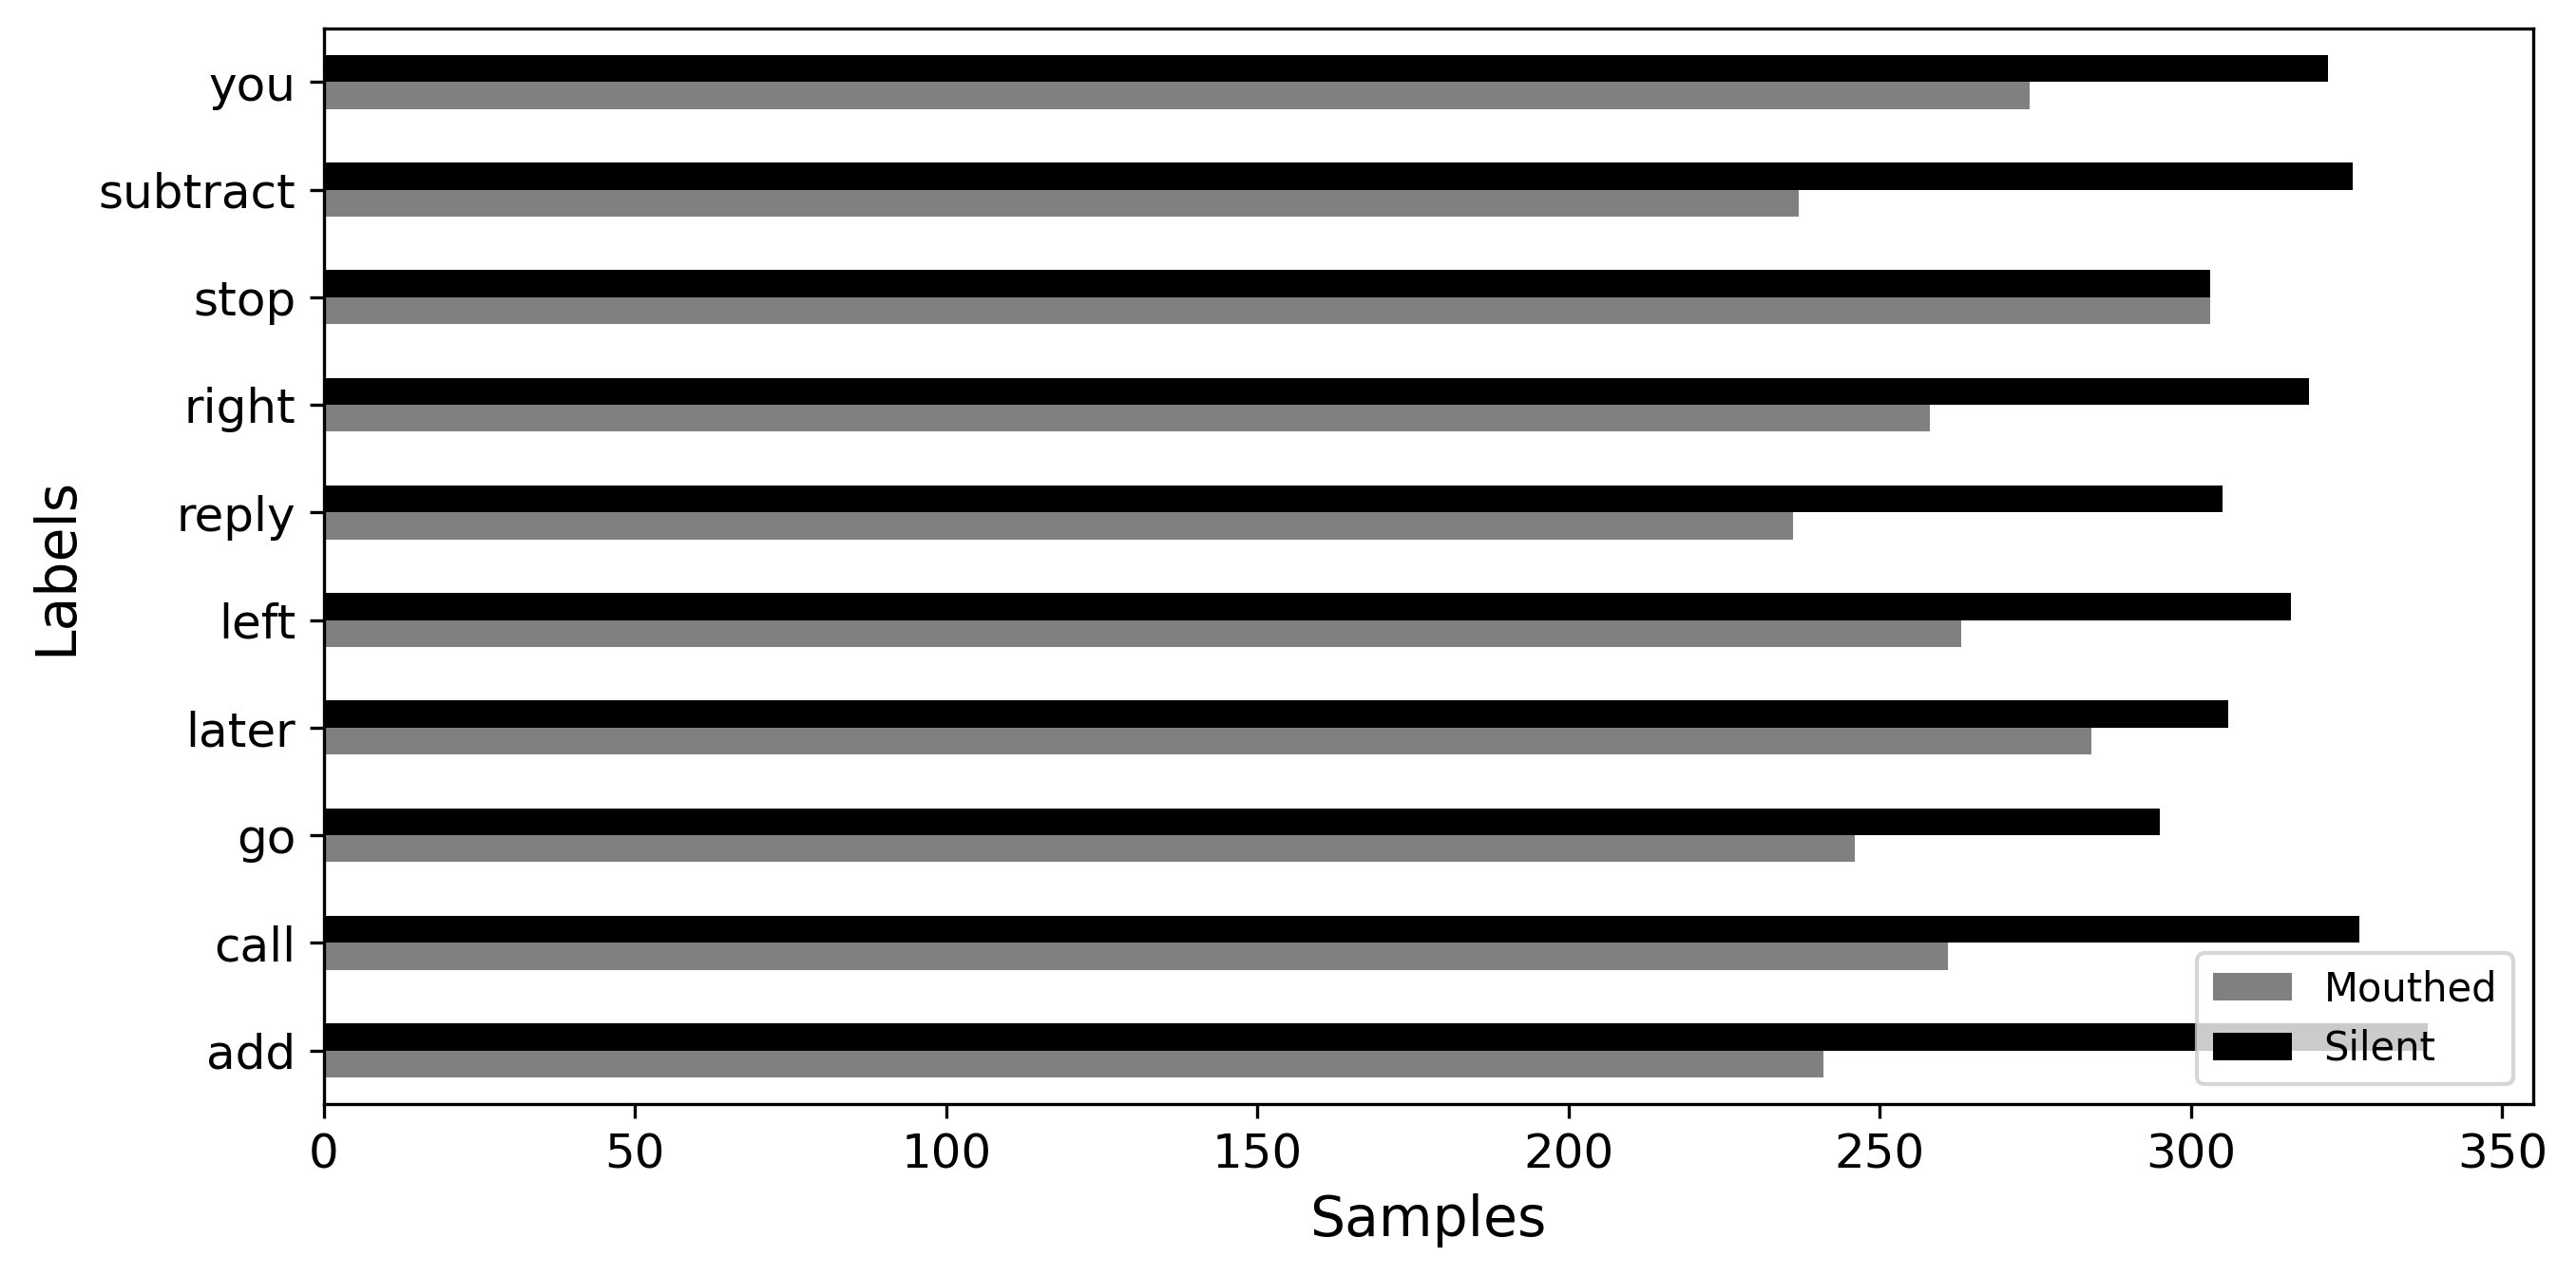

In [7]:
labels = pd.DataFrame({"Mouthed":df_mouthed["word"].value_counts(),
                       "Silent":df_mentally["word"].value_counts()})

labels.plot(kind="barh",rot=0,color={"black","gray"})
plt.xlabel("Samples")
plt.ylabel("Labels")
plt.legend(loc=0,frameon=True)
# save_fig("data distribution by word")
plt.show()

In [8]:
# df_mentally = df_mentally.copy().reset_index(drop=True)

df_mouthed_US.drop(["speaker","mode"],axis=1)
df_mouthed_SR.drop(["speaker","mode"],axis=1)
df_mouthed_RL.drop(["speaker","mode"],axis=1)
df_mouthed_RN.drop(["speaker","mode"],axis=1)

df_mentally_US.drop(["speaker","mode"],axis=1)
df_mentally_SR.drop(["speaker","mode"],axis=1)
df_mentally_RL.drop(["speaker","mode"],axis=1)
df_mentally_RN.drop(["speaker","mode"],axis=1)

X_mouthed_US = df_mouthed_US["data"].values
Y_mouthed_US = df_mouthed_US["word"].values

X_mouthed_SR = df_mouthed_SR["data"].values
Y_mouthed_SR = df_mouthed_SR["word"].values

X_mouthed_RL = df_mouthed_RL["data"].values
Y_mouthed_RL = df_mouthed_RL["word"].values

X_mouthed_RN = df_mouthed_RN["data"].values
Y_mouthed_RN = df_mouthed_RN["word"].values


X_mentally_US = df_mentally_US["data"].values
Y_mentally_US = df_mentally_US["word"].values

X_mentally_SR = df_mentally_SR["data"].values
Y_mentally_SR = df_mentally_SR["word"].values

X_mentally_RL = df_mentally_RL["data"].values
Y_mentally_RL = df_mentally_RL["word"].values

X_mentally_RN = df_mentally_RN["data"].values
Y_mentally_RN = df_mentally_RN["word"].values

### Calculation of Dataset Length in Time

In [9]:
a = np.sum(list(map(len,X_mouthed_US)))
b = np.sum(list(map(len,X_mouthed_SR)))
c = np.sum(list(map(len,X_mouthed_RL)))
d = np.sum(list(map(len,X_mouthed_RN)))

e = np.sum(list(map(len,X_mentally_US)))
f = np.sum(list(map(len,X_mentally_SR)))
g = np.sum(list(map(len,X_mentally_RL)))
h = np.sum(list(map(len,X_mentally_RN)))


In [10]:
print("Total sampled samples in Mouthed: ",a+b+c+d)
# print("Total Length in Mouthed: ",((a+b+c+d)/250)//360)

Total sampled samples in Mouthed:  900210


In [11]:
print("Total sampled samples in Mentally: ",e+f+g+h)

Total sampled samples in Mentally:  1379842


In [12]:
# reshaping X (changing channel columns to rows) 
X_mouthed_US = list(map(np.transpose,X_mouthed_US))
X_mouthed_SR = list(map(np.transpose,X_mouthed_SR))
X_mouthed_RL = list(map(np.transpose,X_mouthed_RL))
X_mouthed_RN = list(map(np.transpose,X_mouthed_RN))

X_mentally_US = list(map(np.transpose,X_mentally_US))
X_mentally_SR = list(map(np.transpose,X_mentally_SR))
X_mentally_RL = list(map(np.transpose,X_mentally_RL))
X_mentally_RN = list(map(np.transpose,X_mentally_RN))


### ANALYSE DATASET

### CORRELATION

In [13]:
def corr(x,y):
    num = np.multiply(x,y)
    den = np.sum(np.square(x) * np.sum(np.square(y)))
    X = np.sum(num)
    Y = np.sqrt(den)
    return X/Y

In [14]:
# requires data of equal length

print("Correlation between same user, same word and same channel: ",corr(X_mouthed_RL[0][0],X_mouthed_RL[0][0]))
print("Correlation between same user, same word and different channel: ",corr(X_mouthed_RL[0][0],X_mouthed_RL[0][2]))
# print("Correlation between different user, same word and same channel: ",corr(X_mouthed_RL[0][0],X_mouthed_RN[0][0]))

Correlation between same user, same word and same channel:  1.0
Correlation between same user, same word and different channel:  0.9999998884227903


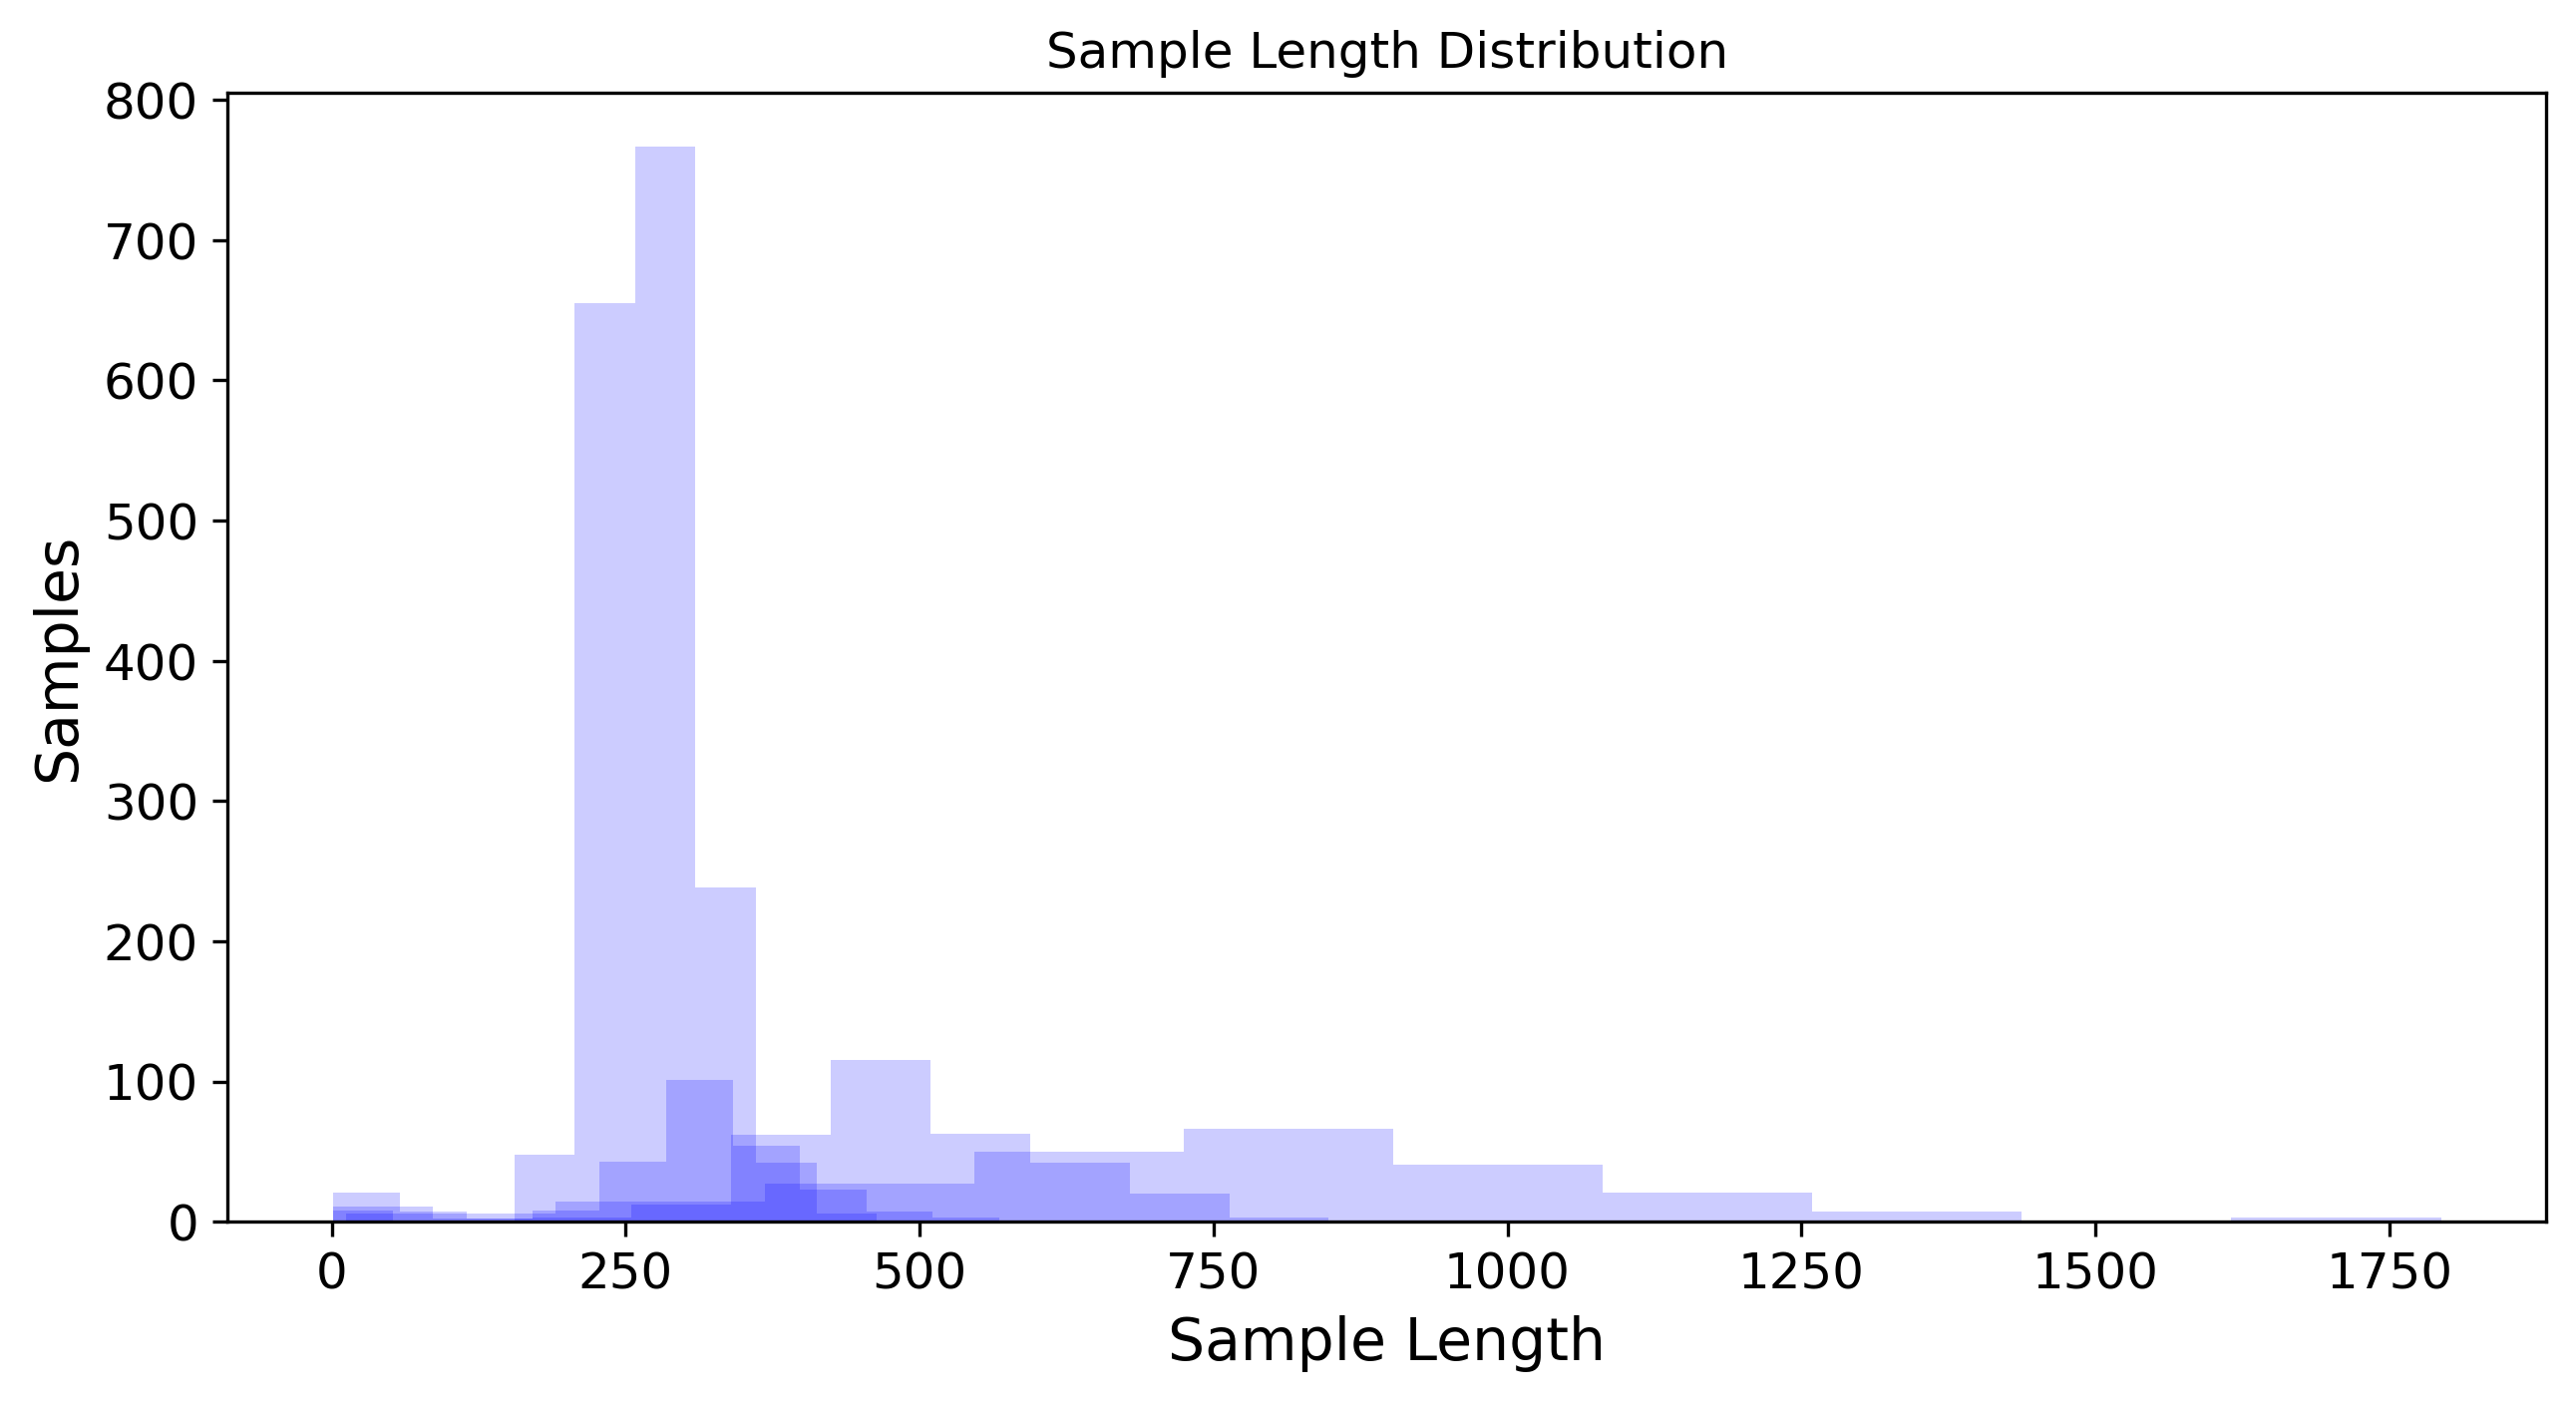

In [15]:
plt.title("Sample Length Distribution")
plt.xlabel("Sample Length")
plt.ylabel("Samples")
plt.hist([len((x[0])) for x in X_mouthed_US],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_SR],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_RL],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_RN],color="b",alpha=0.2)
# save_fig("sample length distribution")
plt.show()

In [16]:
perc = 95
length_95_perc = []
length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_mouthed_US], perc)))]
print(f"The {perc}% of the 'US' data has length lower or equal to {length_95_perc[0]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_mouthed_SR], perc)))]
print(f"The {perc}% of the 'SR' data has length lower or equal to {length_95_perc[1]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_mouthed_RL], perc)))]
print(f"The {perc}% of the 'RL' data has length lower or equal to {length_95_perc[2]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_mouthed_RN], perc)))]
print(f"The {perc}% of the 'RN' data has length lower or equal to {length_95_perc[3]}.")


The 95% of the 'US' data has length lower or equal to 346.
The 95% of the 'SR' data has length lower or equal to 444.
The 95% of the 'RL' data has length lower or equal to 1206.
The 95% of the 'RN' data has length lower or equal to 711.


### DROPPING SHORT AND VERY LONG DATA

In [17]:
def drop_data(X,Y,MIN=100,MAX=900):
    index = []
    for i in range(len(X)):
        if(len(X[i][0])<MIN or len(X[i][0])>MAX):
#             print(len(X[i][0]))
            continue
        index.append(i)
    return [X[n] for n in index],[Y[n] for n in index]

In [18]:
X_mouthed_US,Y_mouthed_US = drop_data(X_mouthed_US,Y_mouthed_US)
X_mouthed_SR,Y_mouthed_SR = drop_data(X_mouthed_SR,Y_mouthed_SR)
X_mouthed_RL,Y_mouthed_RL = drop_data(X_mouthed_RL,Y_mouthed_RL)
X_mouthed_RN,Y_mouthed_RN = drop_data(X_mouthed_RN,Y_mouthed_RN)

X_mentally_US,Y_mentally_US = drop_data(X_mentally_US,Y_mentally_US)
X_mentally_SR,Y_mentally_SR = drop_data(X_mentally_SR,Y_mentally_SR)
X_mentally_RL,Y_mentally_RL = drop_data(X_mentally_RL,Y_mentally_RL)
X_mentally_RN,Y_mentally_RN = drop_data(X_mentally_RN,Y_mentally_RN)

print("NEW US SAMPLES: ",len(X_mouthed_US))
print("NEW SR SAMPLES: ",len(X_mouthed_SR))
print("NEW RL SAMPLES: ",len(X_mouthed_RL))
print("NEW RN SAMPLES: ",len(X_mouthed_RN))

NEW US SAMPLES:  1758
NEW SR SAMPLES:  246
NEW RL SAMPLES:  159
NEW RN SAMPLES:  322


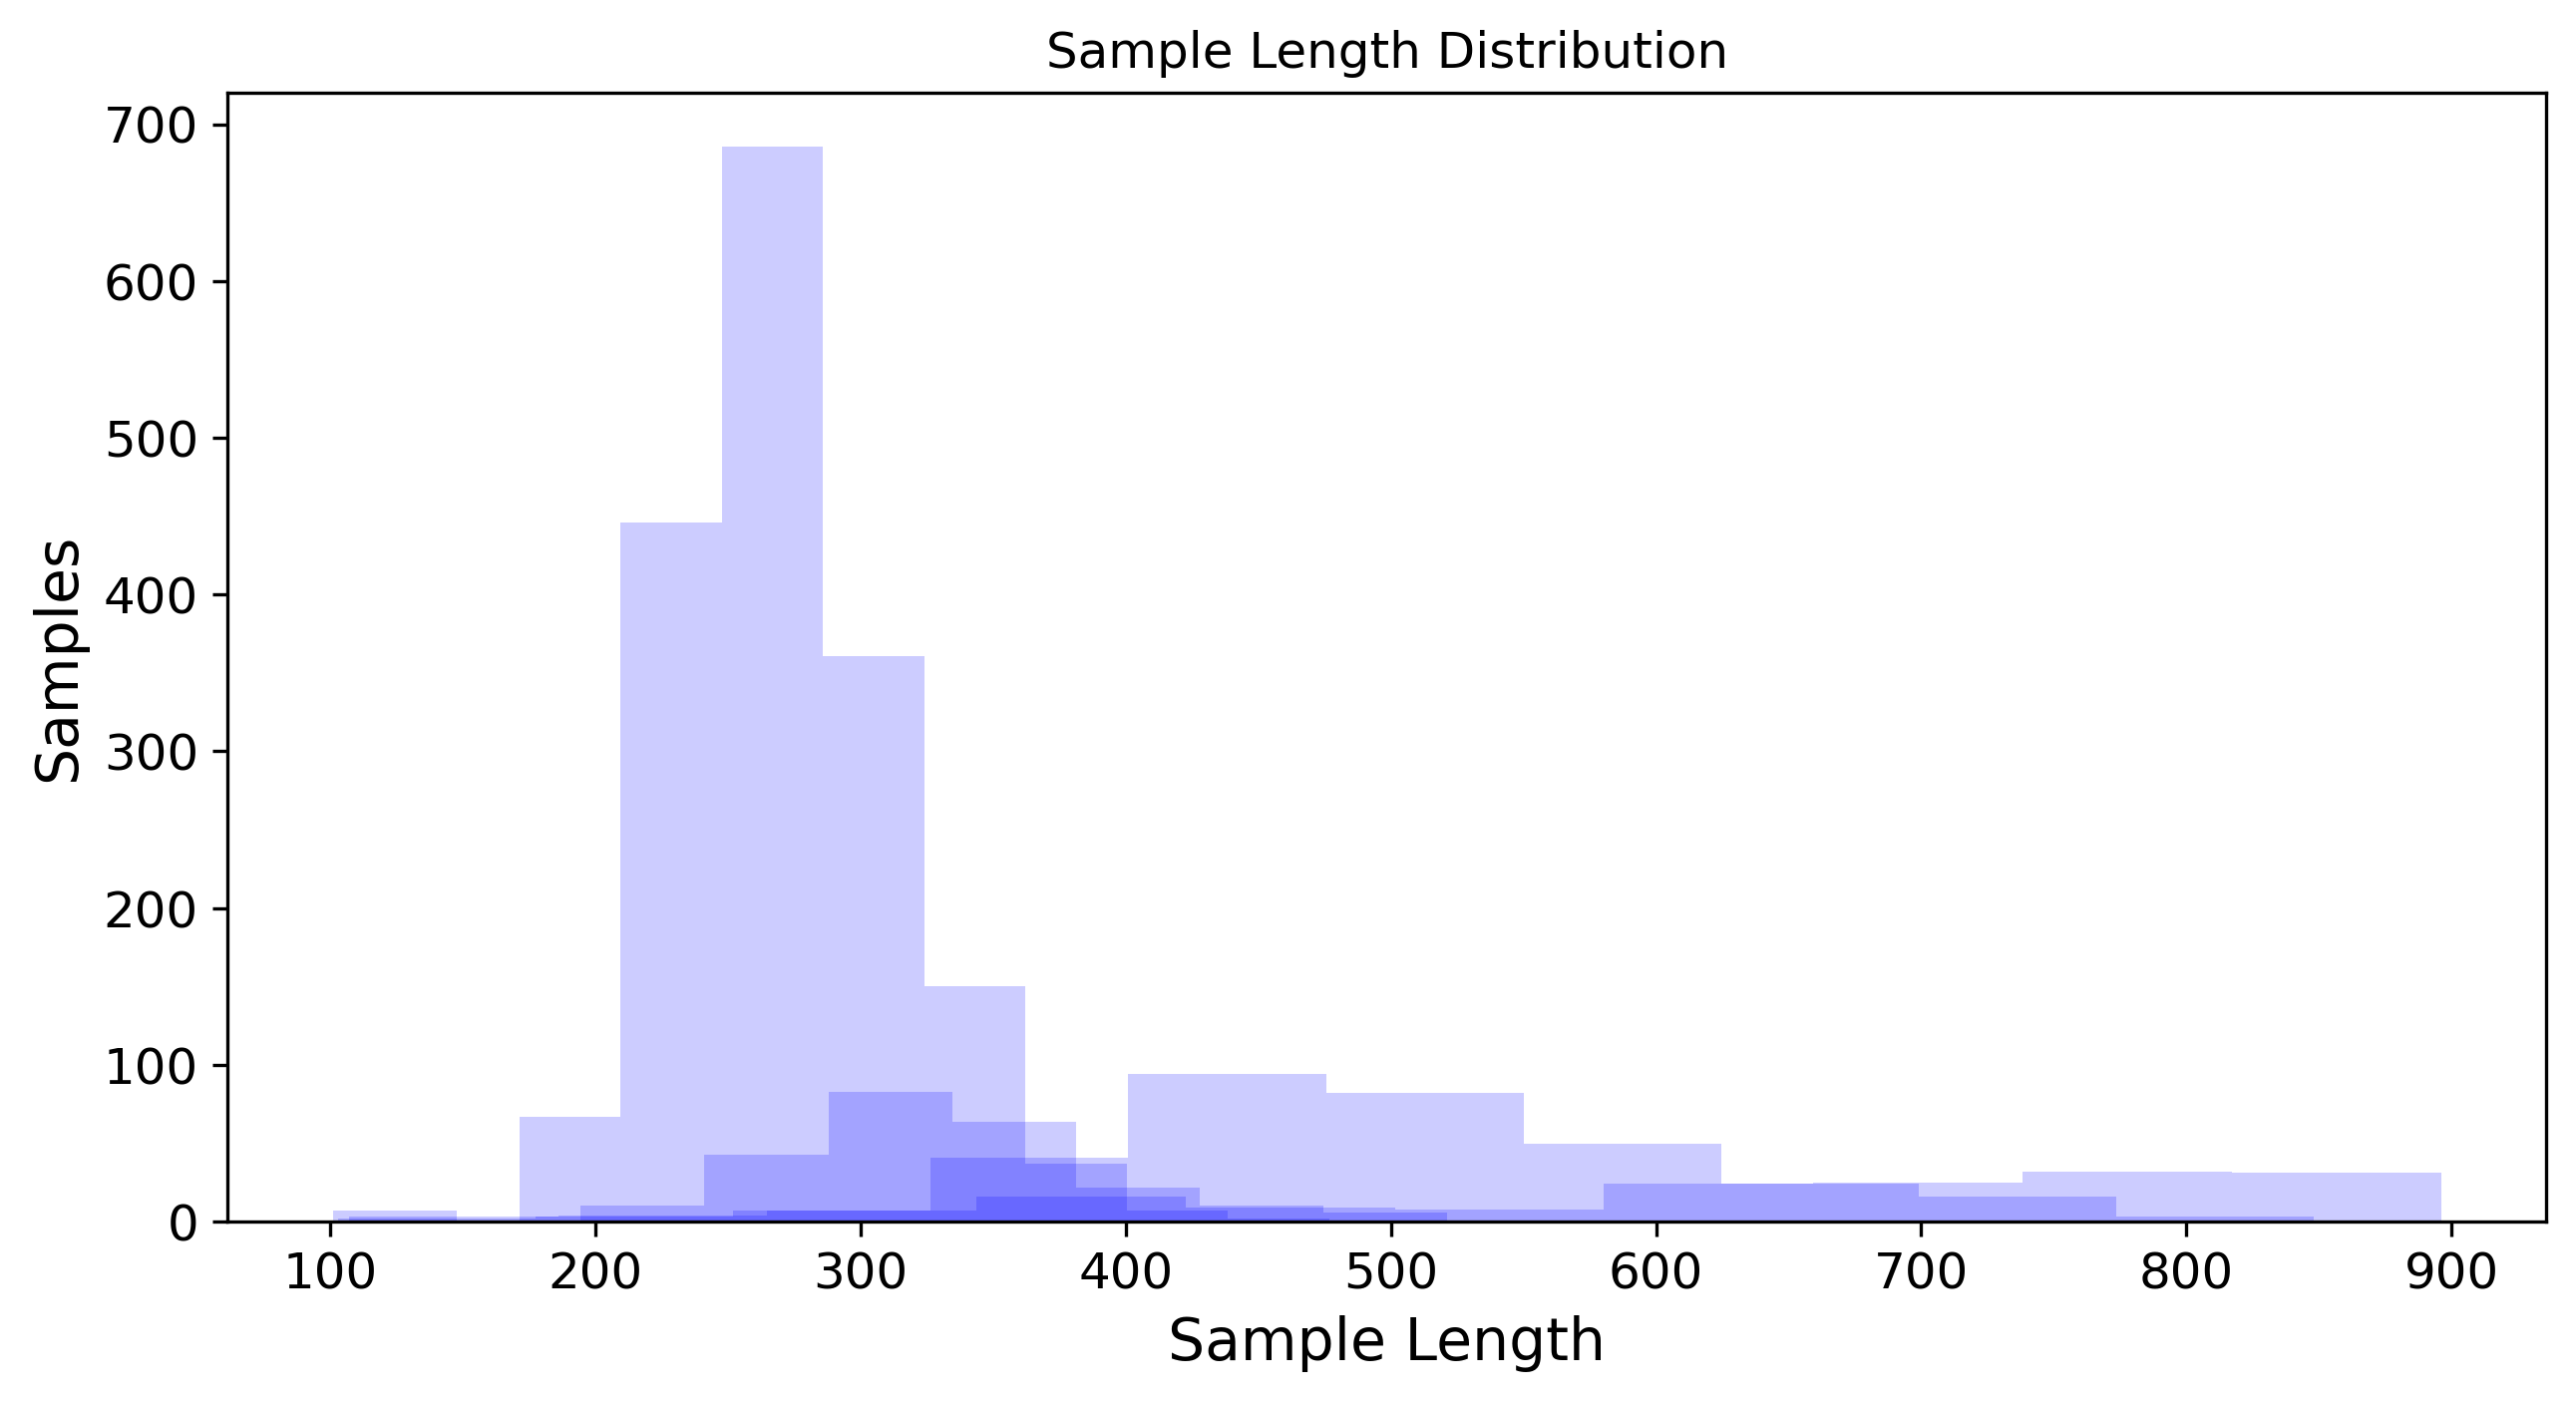

In [19]:
plt.title("Sample Length Distribution")
plt.xlabel("Sample Length")
plt.ylabel("Samples")
plt.hist([len((x[0])) for x in X_mouthed_US],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_SR],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_RL],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_RN],color="b",alpha=0.2)
# save_fig("sample length distribution selected samples(MIN100MAX900)")
plt.show()

In [20]:
perc = 95
length_95_perc = []
length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_mouthed_US], perc)))]
print(f"The {perc}% of the 'US' data has length lower or equal to {length_95_perc[0]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_mouthed_SR], perc)))]
print(f"The {perc}% of the 'SR' data has length lower or equal to {length_95_perc[1]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_mouthed_RL], perc)))]
print(f"The {perc}% of the 'RL' data has length lower or equal to {length_95_perc[2]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_mouthed_RN], perc)))]
print(f"The {perc}% of the 'RN' data has length lower or equal to {length_95_perc[3]}.")


The 95% of the 'US' data has length lower or equal to 346.
The 95% of the 'SR' data has length lower or equal to 447.
The 95% of the 'RL' data has length lower or equal to 868.
The 95% of the 'RN' data has length lower or equal to 711.


# SIGNAL PROCESSING PIPELINE

### SIGNAL SMOOTHING --> SIGNAL NORMALIZATION --> DIGITAL FILTERING

### SIGNAL SMOOTHING

In [21]:
def smoother(X,Y,POINTS=8):
    """
    SMOOTHES THE INPUT SIGNAL AVERAGING OVER 8 DATA POINTS (ARNAV)
    """
    new_X = []
    for SIGNAL,index in zip(X,tqdm.tqdm(range(len(X)),desc="Smoothing Signal")):
        XX = [] 
        for channel in range(NUM_CHANNELS):
            XXX = []
            for i in range(len(SIGNAL[channel])):
                a = i
                b = i+POINTS
                if(b>len(SIGNAL[channel])): break
                XXX.append(int((np.sum(SIGNAL[channel][a:b]))/POINTS))
            XX.append(np.array(XXX))
        new_X.append(np.vstack(XX))
    return new_X,Y

In [22]:
p, l = smoother(X_mouthed_RL,Y_mouthed_RL)

Smoothing Signal:  99%|█████████▉| 158/159 [00:08<00:00, 17.69it/s]


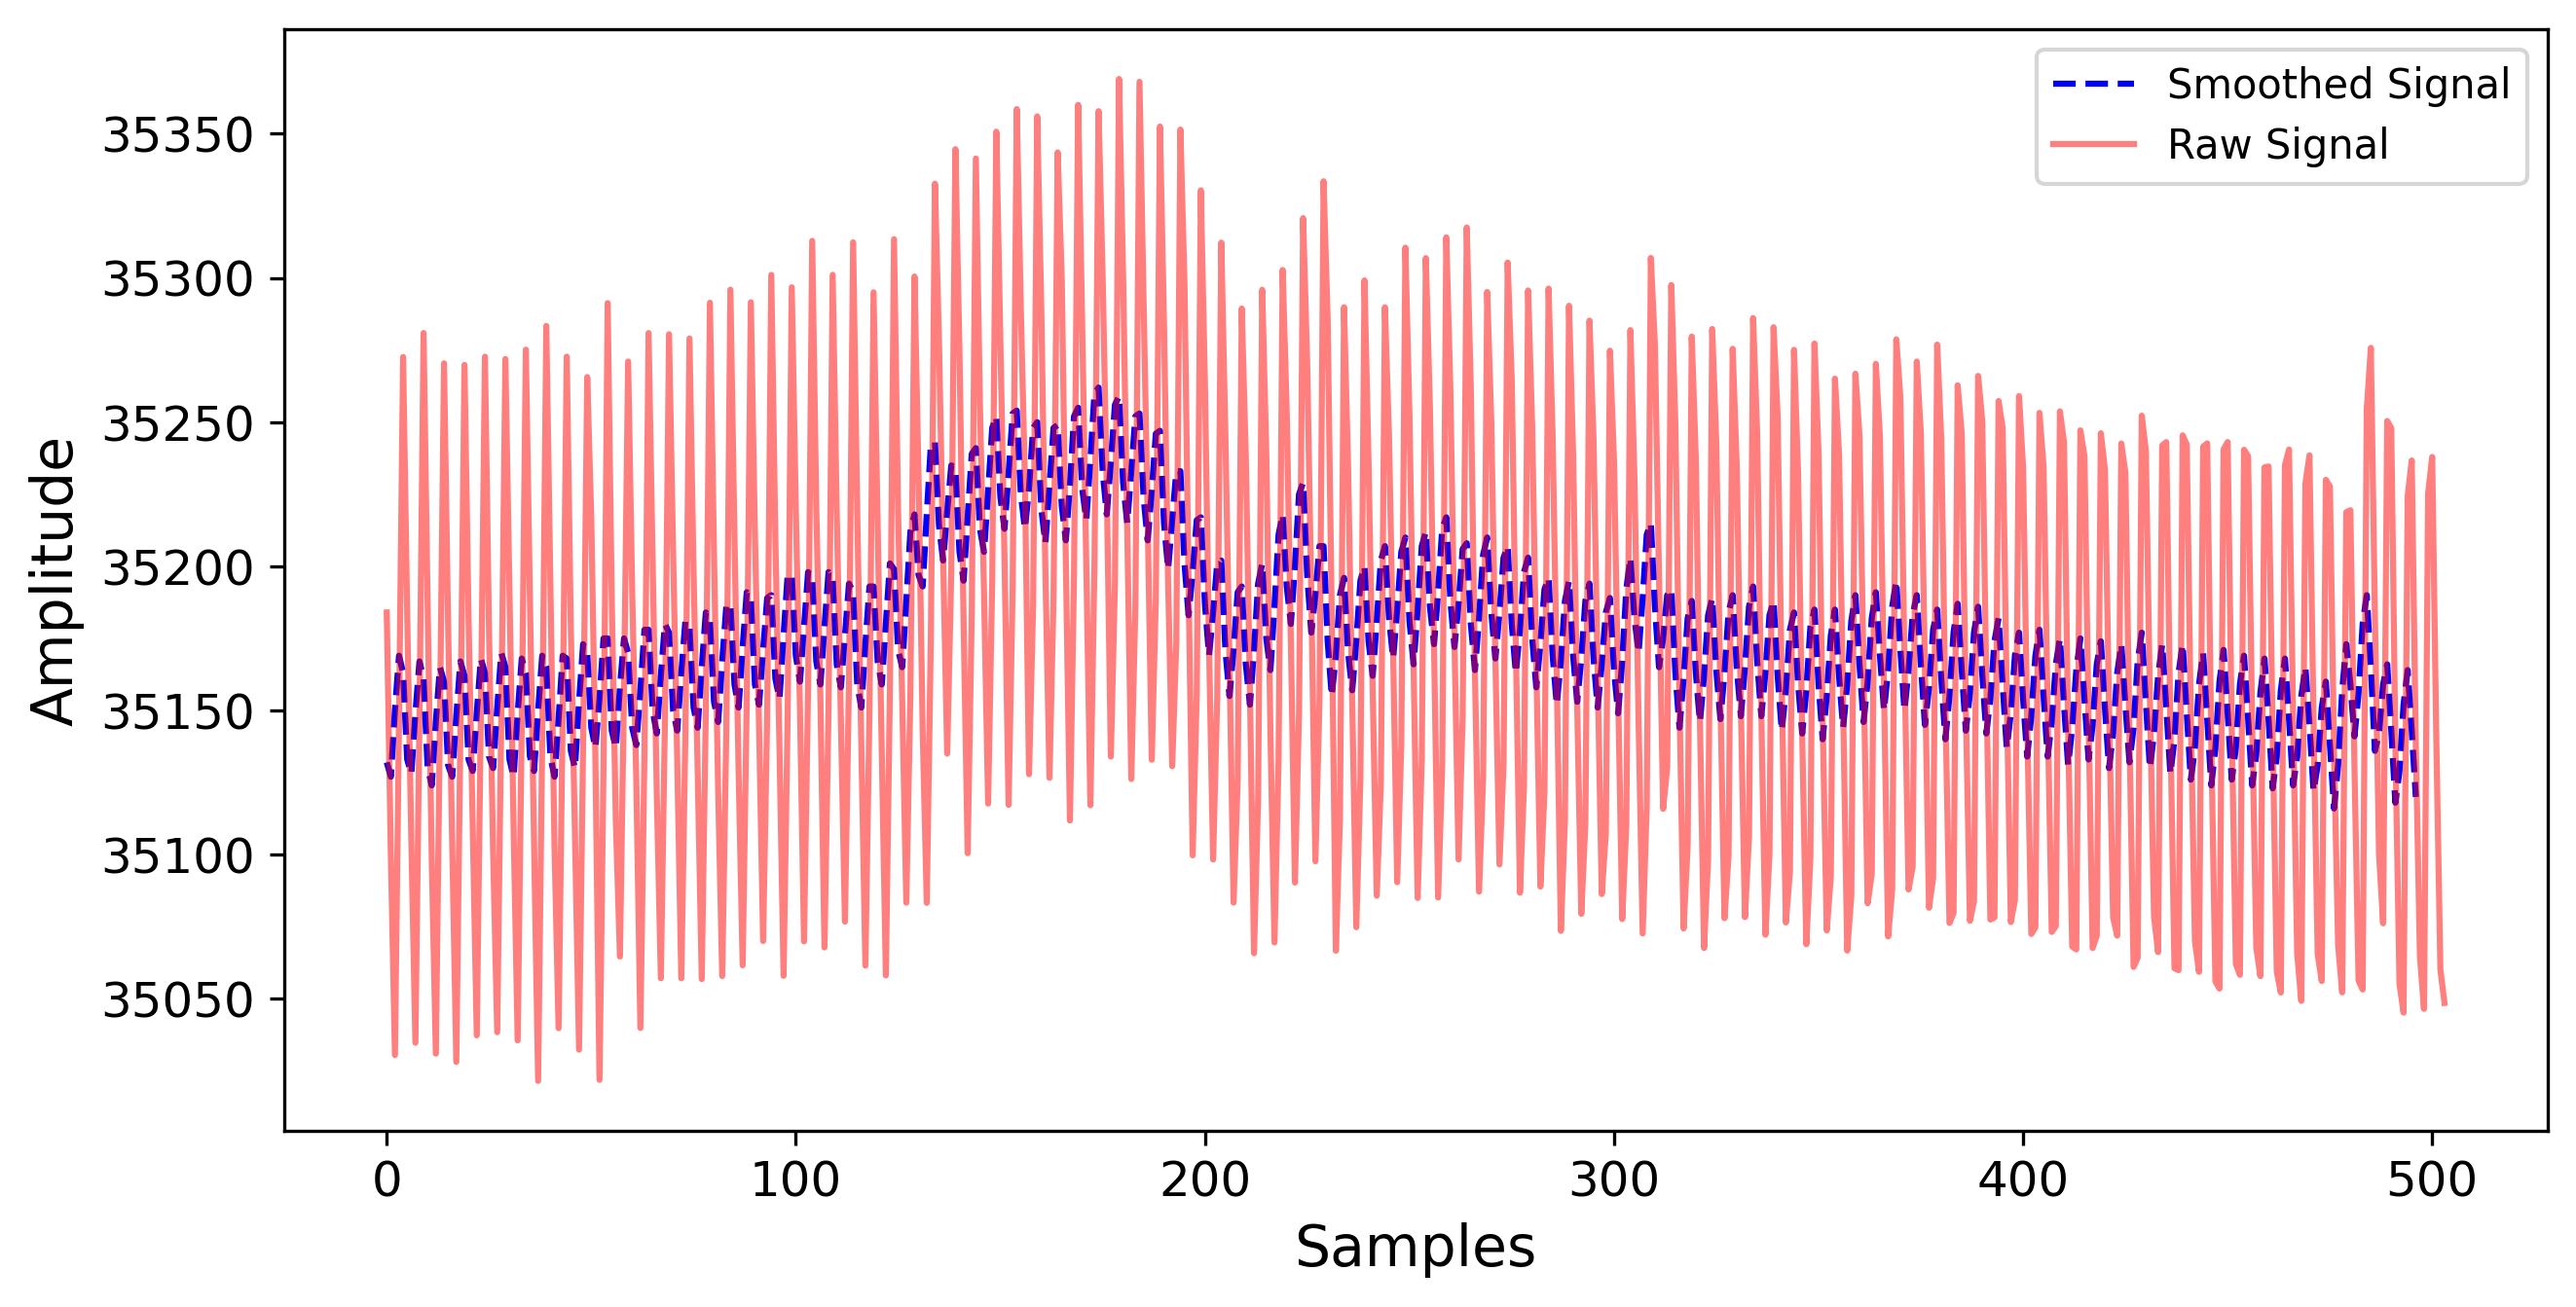

In [23]:
plt.plot(p[0][7],"b--")
plt.plot(X_mouthed_RL[0][7],"r",alpha=0.5)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend(["Smoothed Signal","Raw Signal"])
# save_fig("signal smoothing")

### DIGITAL FILTERS

In [24]:
# filter definition
def digital_filter(SIGNAL,HPF,LPF,ORDER,RICKER=False):
    def butterworth(TYPE,CUTOFF,data,ORDER=1,SR=SAMPLING_FREQ,OUTPUT='sos'):
        """
        IIR BUTTERWORTH FILTER 
        TYPE: "highpass","lowpass","bandpass"
        data: input signal
        CUTOFF: cut-off frequency of the filter
        """
        sos = signal.butter(ORDER,CUTOFF,TYPE,fs=SR,output=OUTPUT)
        return signal.sosfilt(sos,data)

    def notch(data,FREQUENCY=50,Q_FACTOR=30,SR=SAMPLING_FREQ):
        """
        NOTCH FILTER
        data: input signal
        """
        b,a = signal.iirnotch(FREQUENCY,Q_FACTOR,SR)
        return signal.lfilter(b,a,data)
    
    def ricker(SIGNAL,sample_rate=250):
        """
        RICKER CONVOLUTION TO REMOVE HEARTBEAT ARTIFACTS
        """
        ricker_width = 35 * sample_rate // 250
        ricker_sigma = 4.0 * sample_rate / 250
        ricker = signal.ricker(ricker_width,ricker_sigma)
        # normalize ricker
        ricker = np.array(ricker, np.float32) / np.sum(np.abs(ricker))
        convolution = signal.convolve(SIGNAL,ricker,mode="same")
        return (SIGNAL-2*convolution)

    SIGNAL = butterworth("highpass",HPF,SIGNAL,ORDER=ORDER)
    SIGNAL = notch(SIGNAL)
    SIGNAL = butterworth("lowpass",LPF,SIGNAL,ORDER=ORDER)
    if(RICKER):
        SIGNAL = ricker(SIGNAL)
    return SIGNAL


# filter application
def apply_filter(X,Y,HPF=1.5,LPF=50,ORDER=1,RICKER=False):
    """
    HPF -> LPF -> NOTCH -> RICKER
    """
    new_X = []
    for SIGNAL,index in zip(X,tqdm.tqdm(range(len(X)),desc="Filtering Signal")):
        XX = []
        for channel in range(NUM_CHANNELS):
            XX.append(digital_filter(zscore(SIGNAL[channel]),HPF=HPF,LPF=LPF,ORDER=ORDER,RICKER=RICKER))
        new_X.append(np.vstack(XX))

    return new_X,Y

In [25]:
p, l = apply_filter(X_mouthed_RL,Y_mouthed_RL,RICKER=True)
q, l = apply_filter(X_mouthed_RL,Y_mouthed_RL,RICKER=False)

Filtering Signal:  99%|█████████▉| 158/159 [00:02<00:00, 58.19it/s]


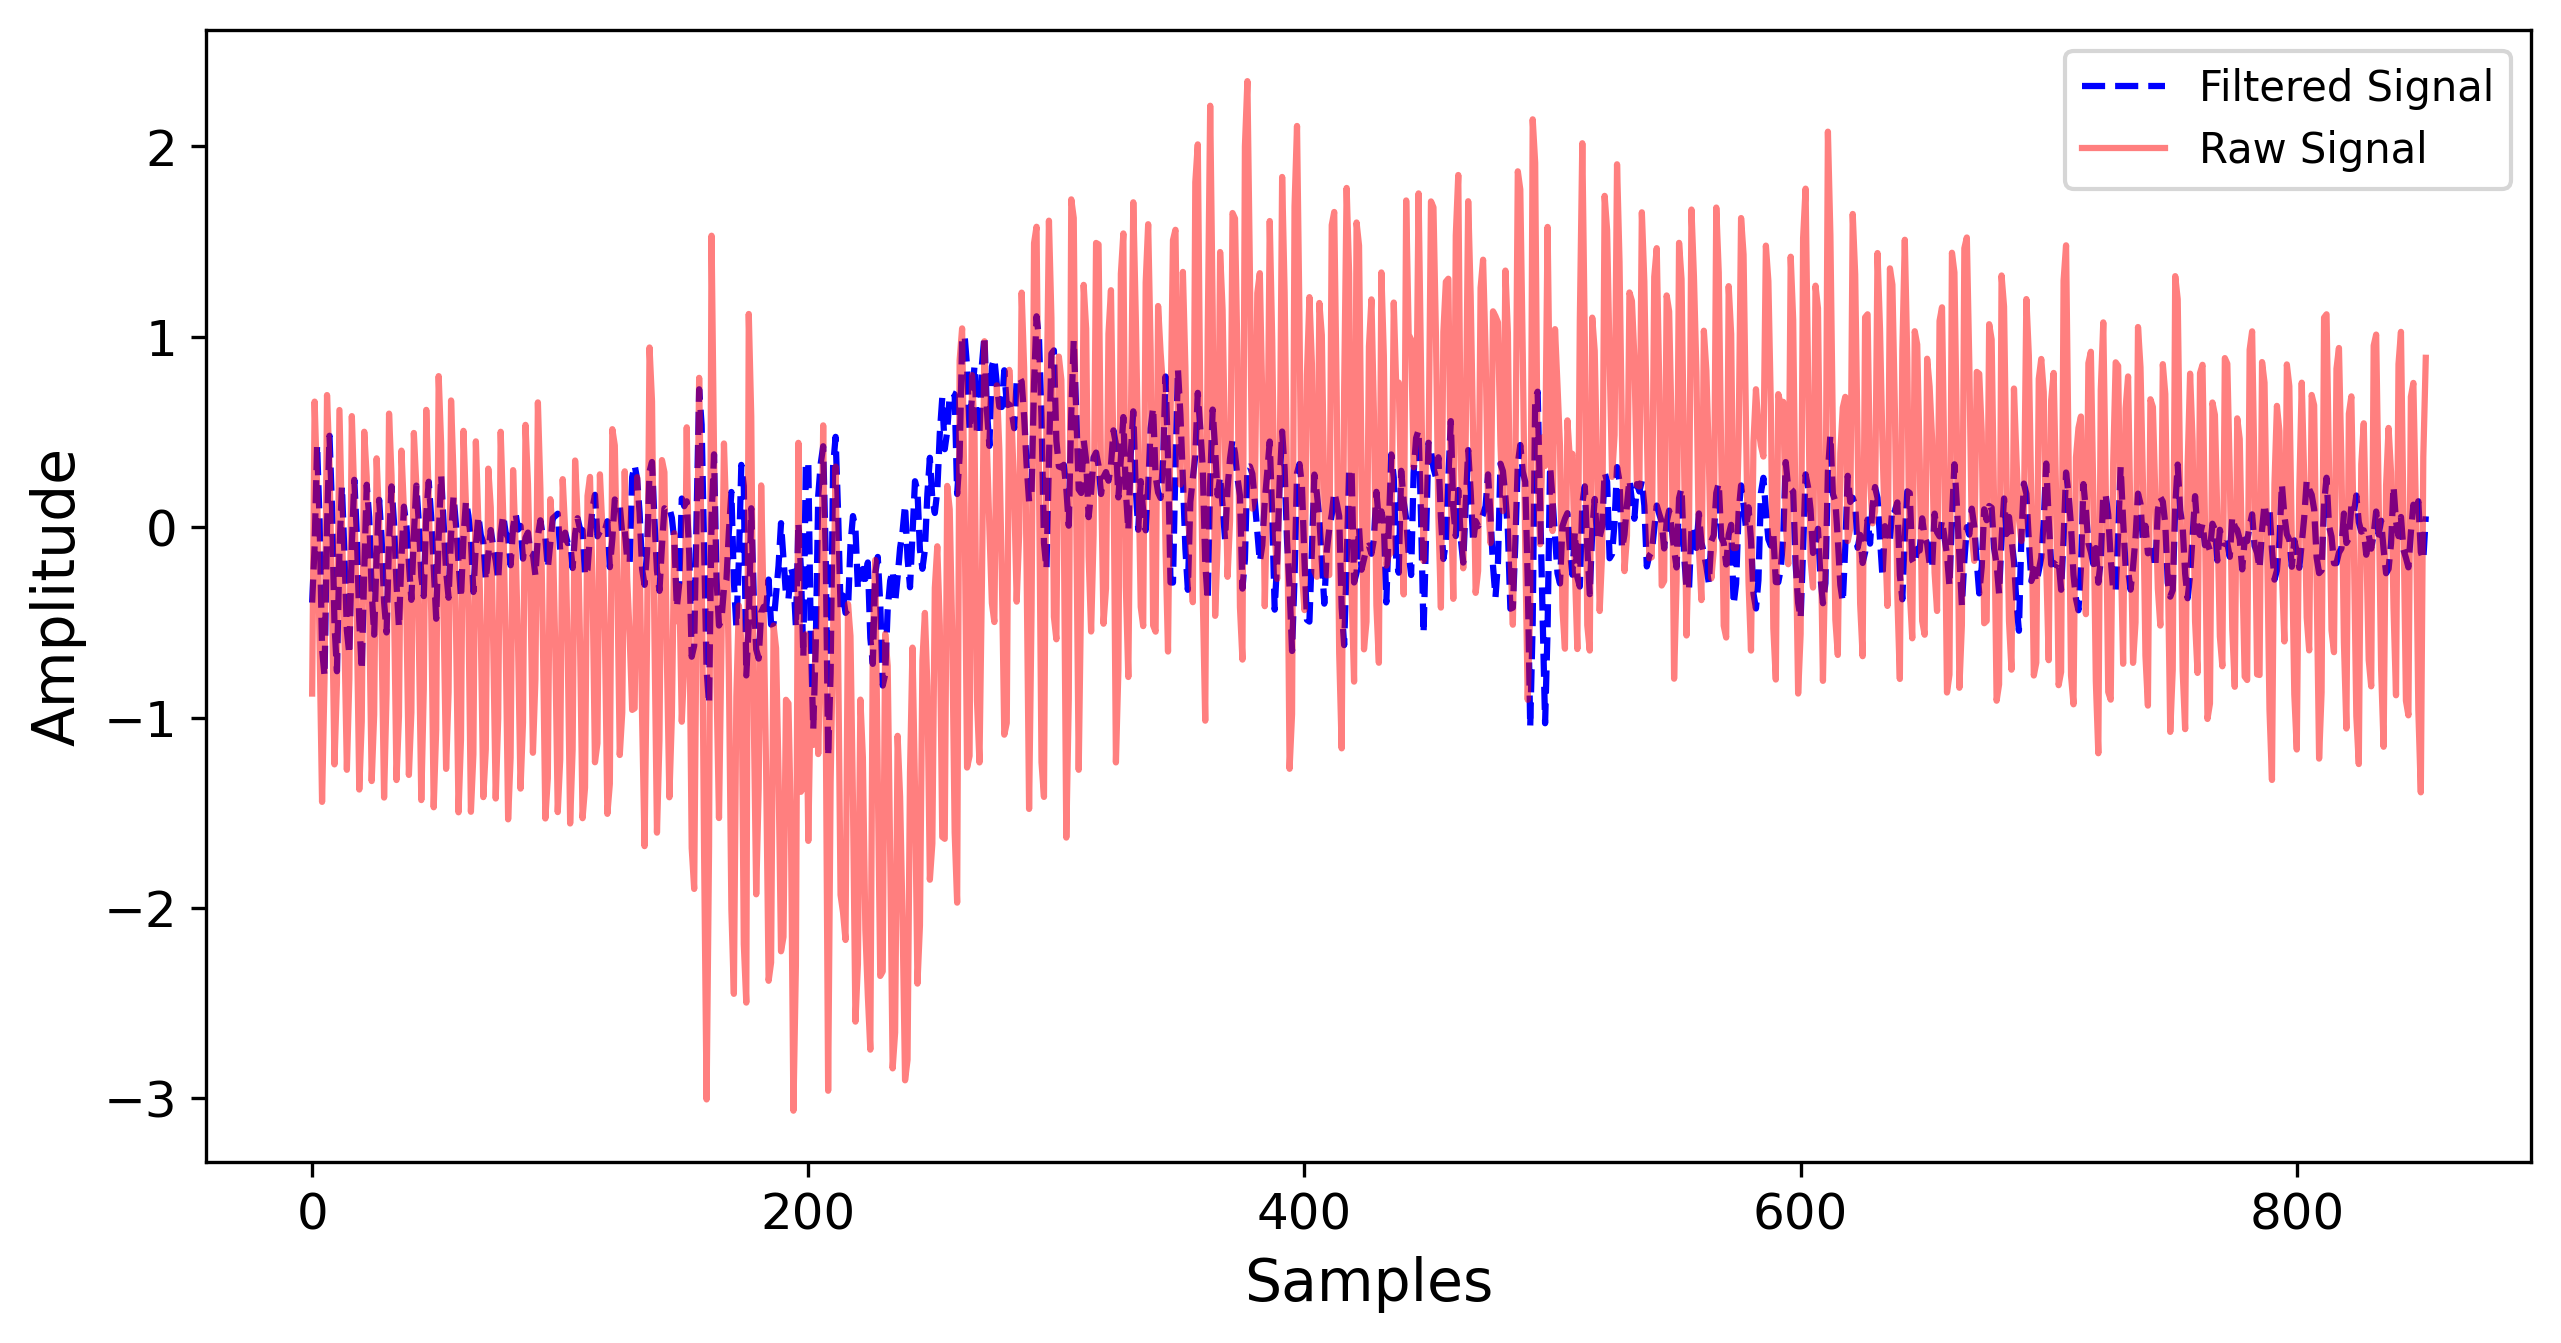

In [26]:
plt.plot(p[20][3],"b--")
plt.plot(zscore(X_mouthed_RL[20][3]),"r",alpha=0.5)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend(["Filtered Signal","Raw Signal"])
# save_fig("signal smoothing")

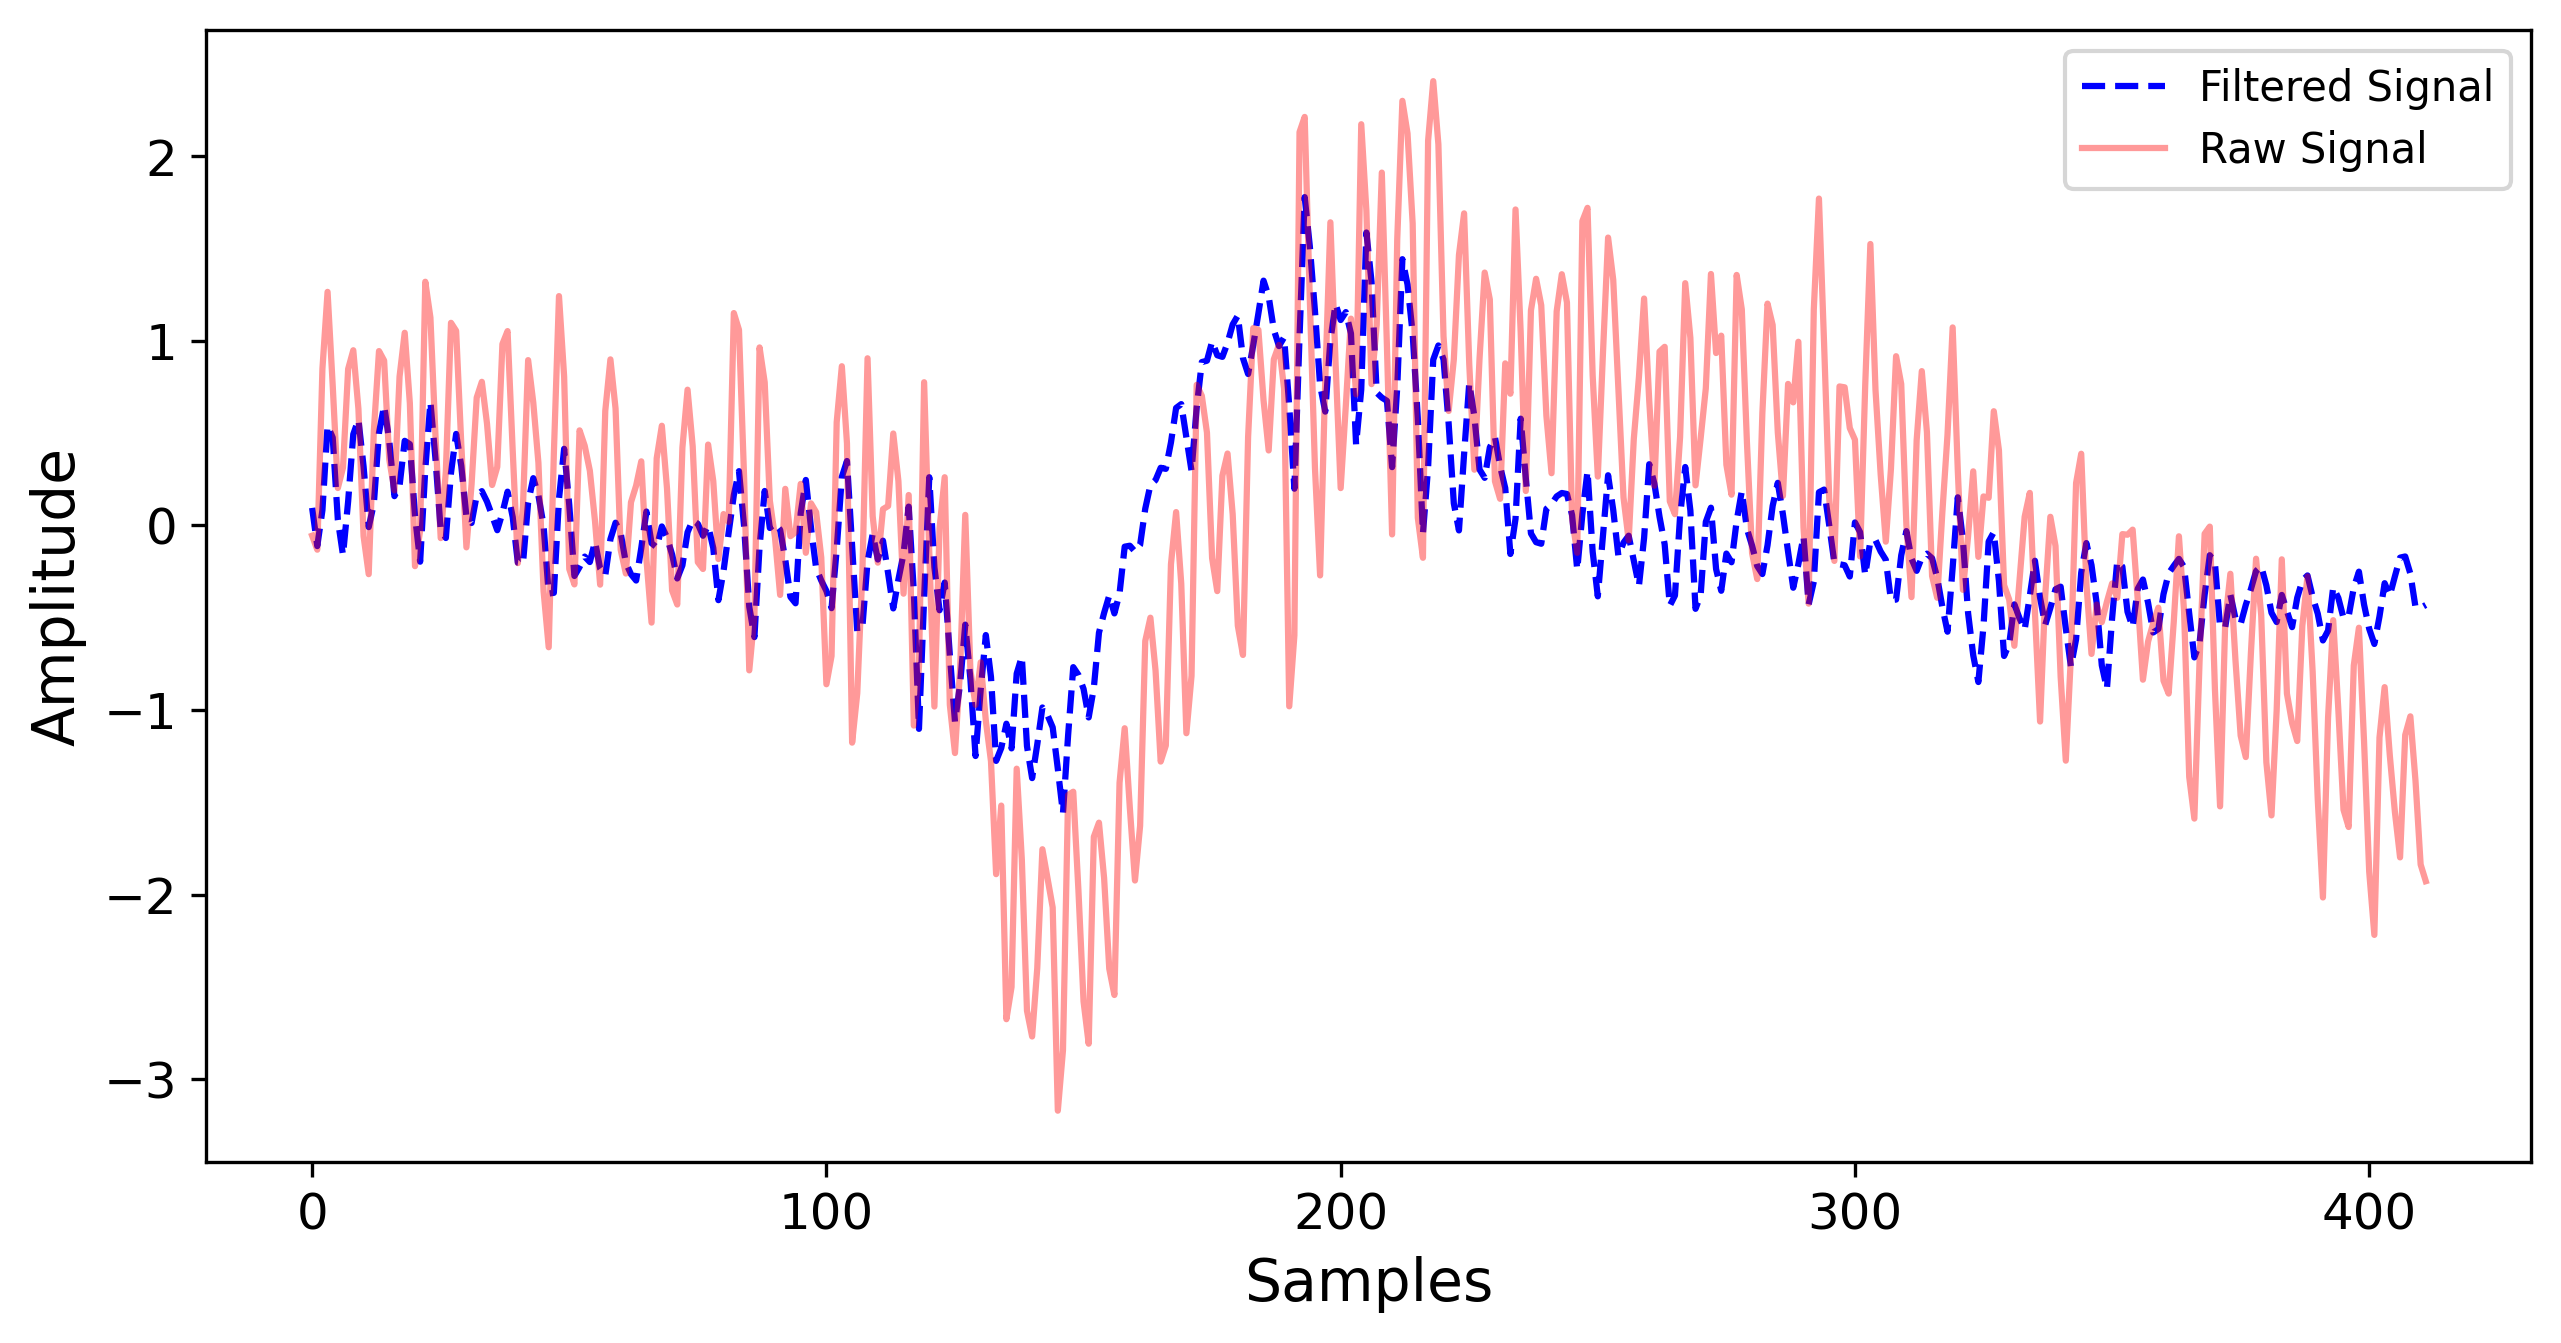

In [27]:
plt.plot(p[10][3],"b--")
plt.plot(zscore(X_mouthed_RL[10][3]),"r",alpha=0.4)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend(["Filtered Signal","Raw Signal"])
# save_fig("Filtered signal")

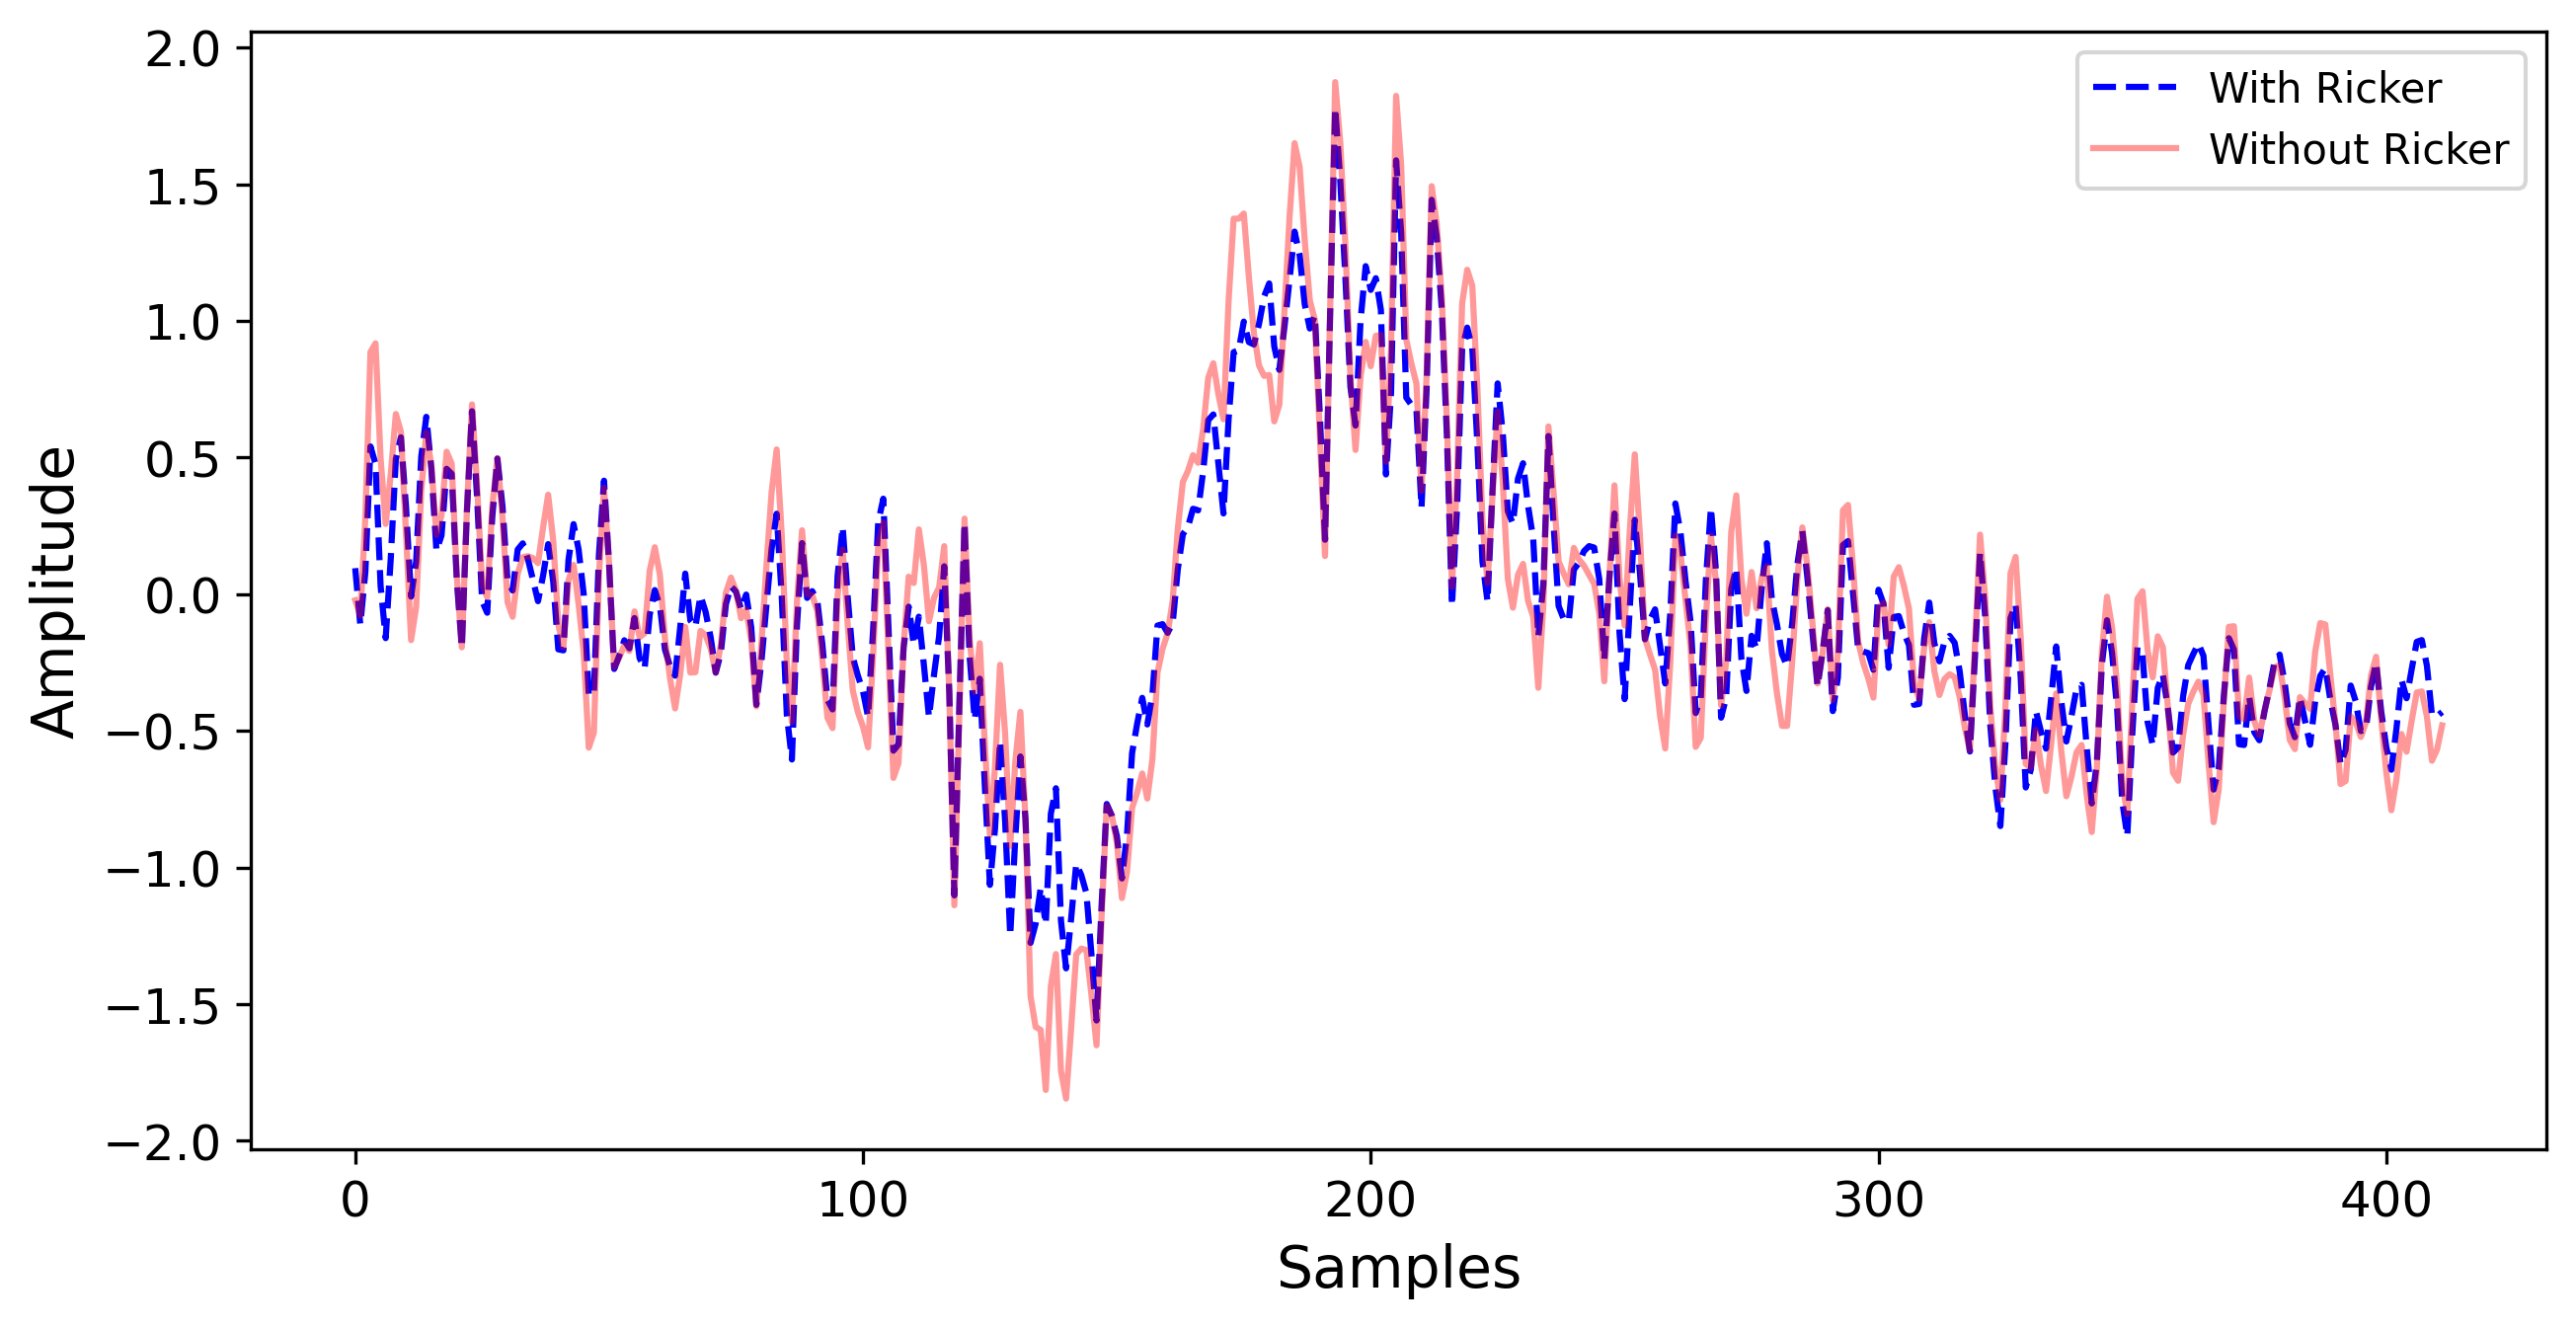

In [28]:
plt.plot(p[10][3],"b--")
plt.plot(q[10][3],"r",alpha=0.4)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend(["With Ricker","Without Ricker"])
# save_fig("with and without ricker(2)")

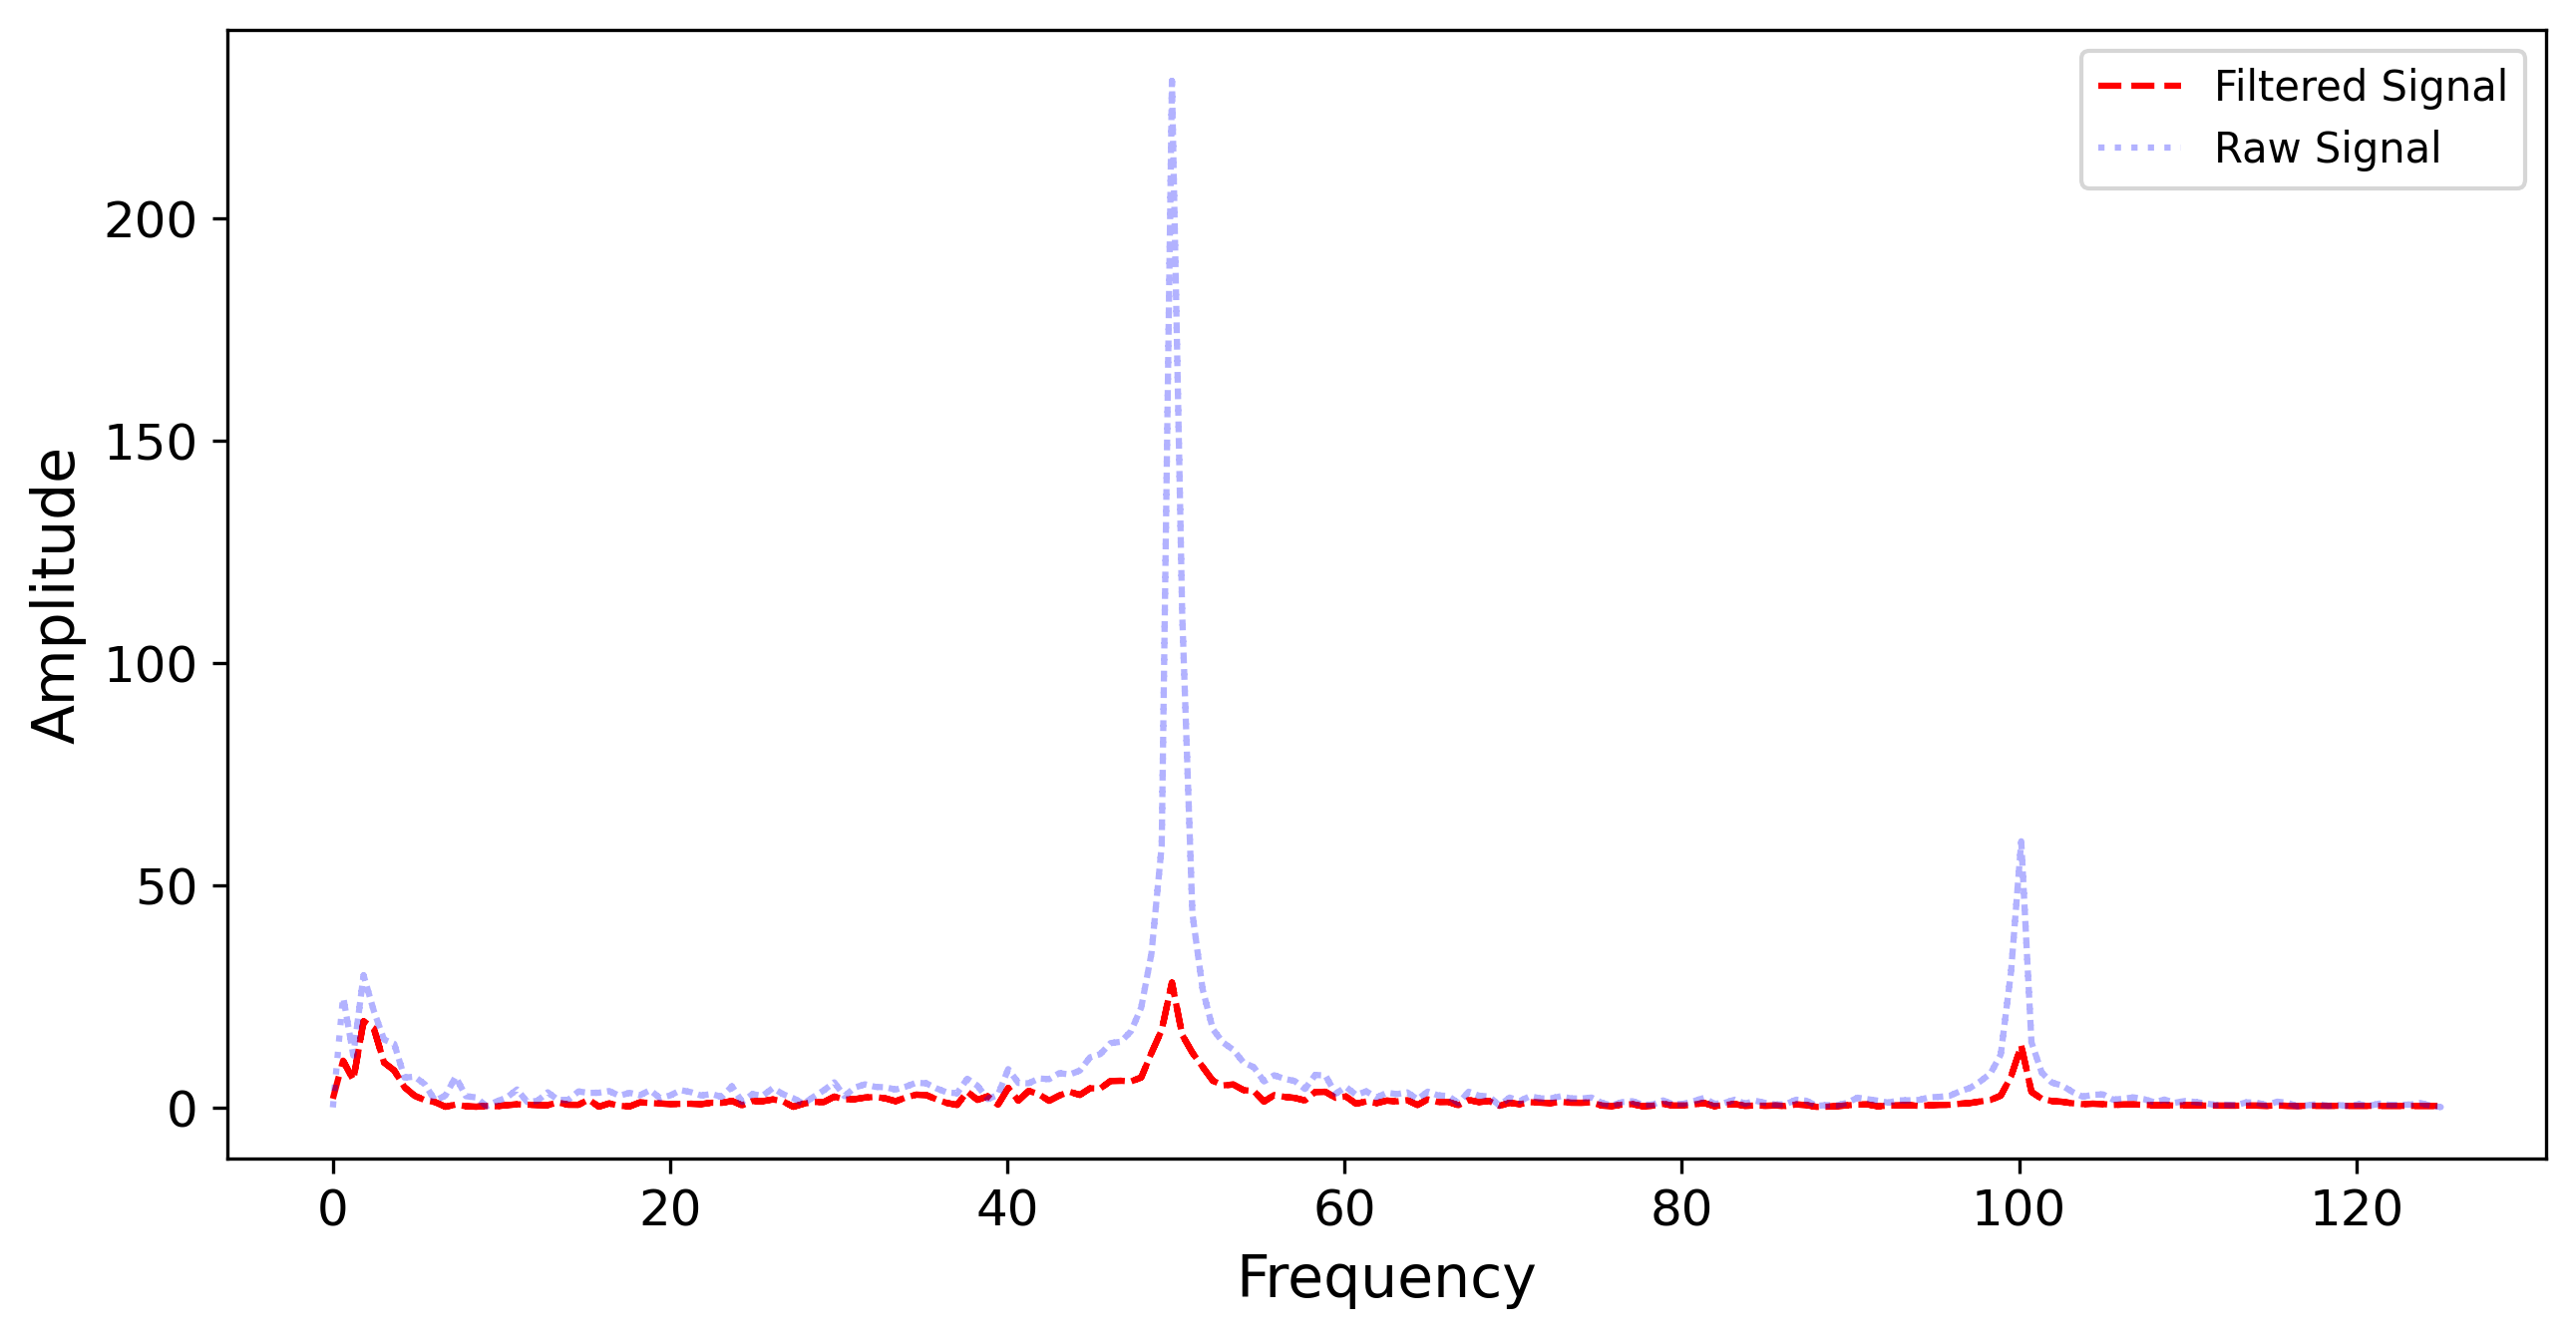

In [29]:
# checking filtered signal of a random instance

from scipy.fft import fft,fftfreq

N = len(p[10][2])
y = fft(p[10][2])
x = fftfreq(N,1/250)
plt.plot(abs(x),abs(y),"r--")

N = len(X_mouthed_RL[10][2])
y = fft(zscore(X_mouthed_RL[10][2]))
x = fftfreq(N,1/250)
plt.plot(abs(x),abs(y),"b:",alpha=0.3)
plt.legend(["Filtered Signal","Raw Signal"])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
# save_fig("fft raw and filtered signal")
plt.show()

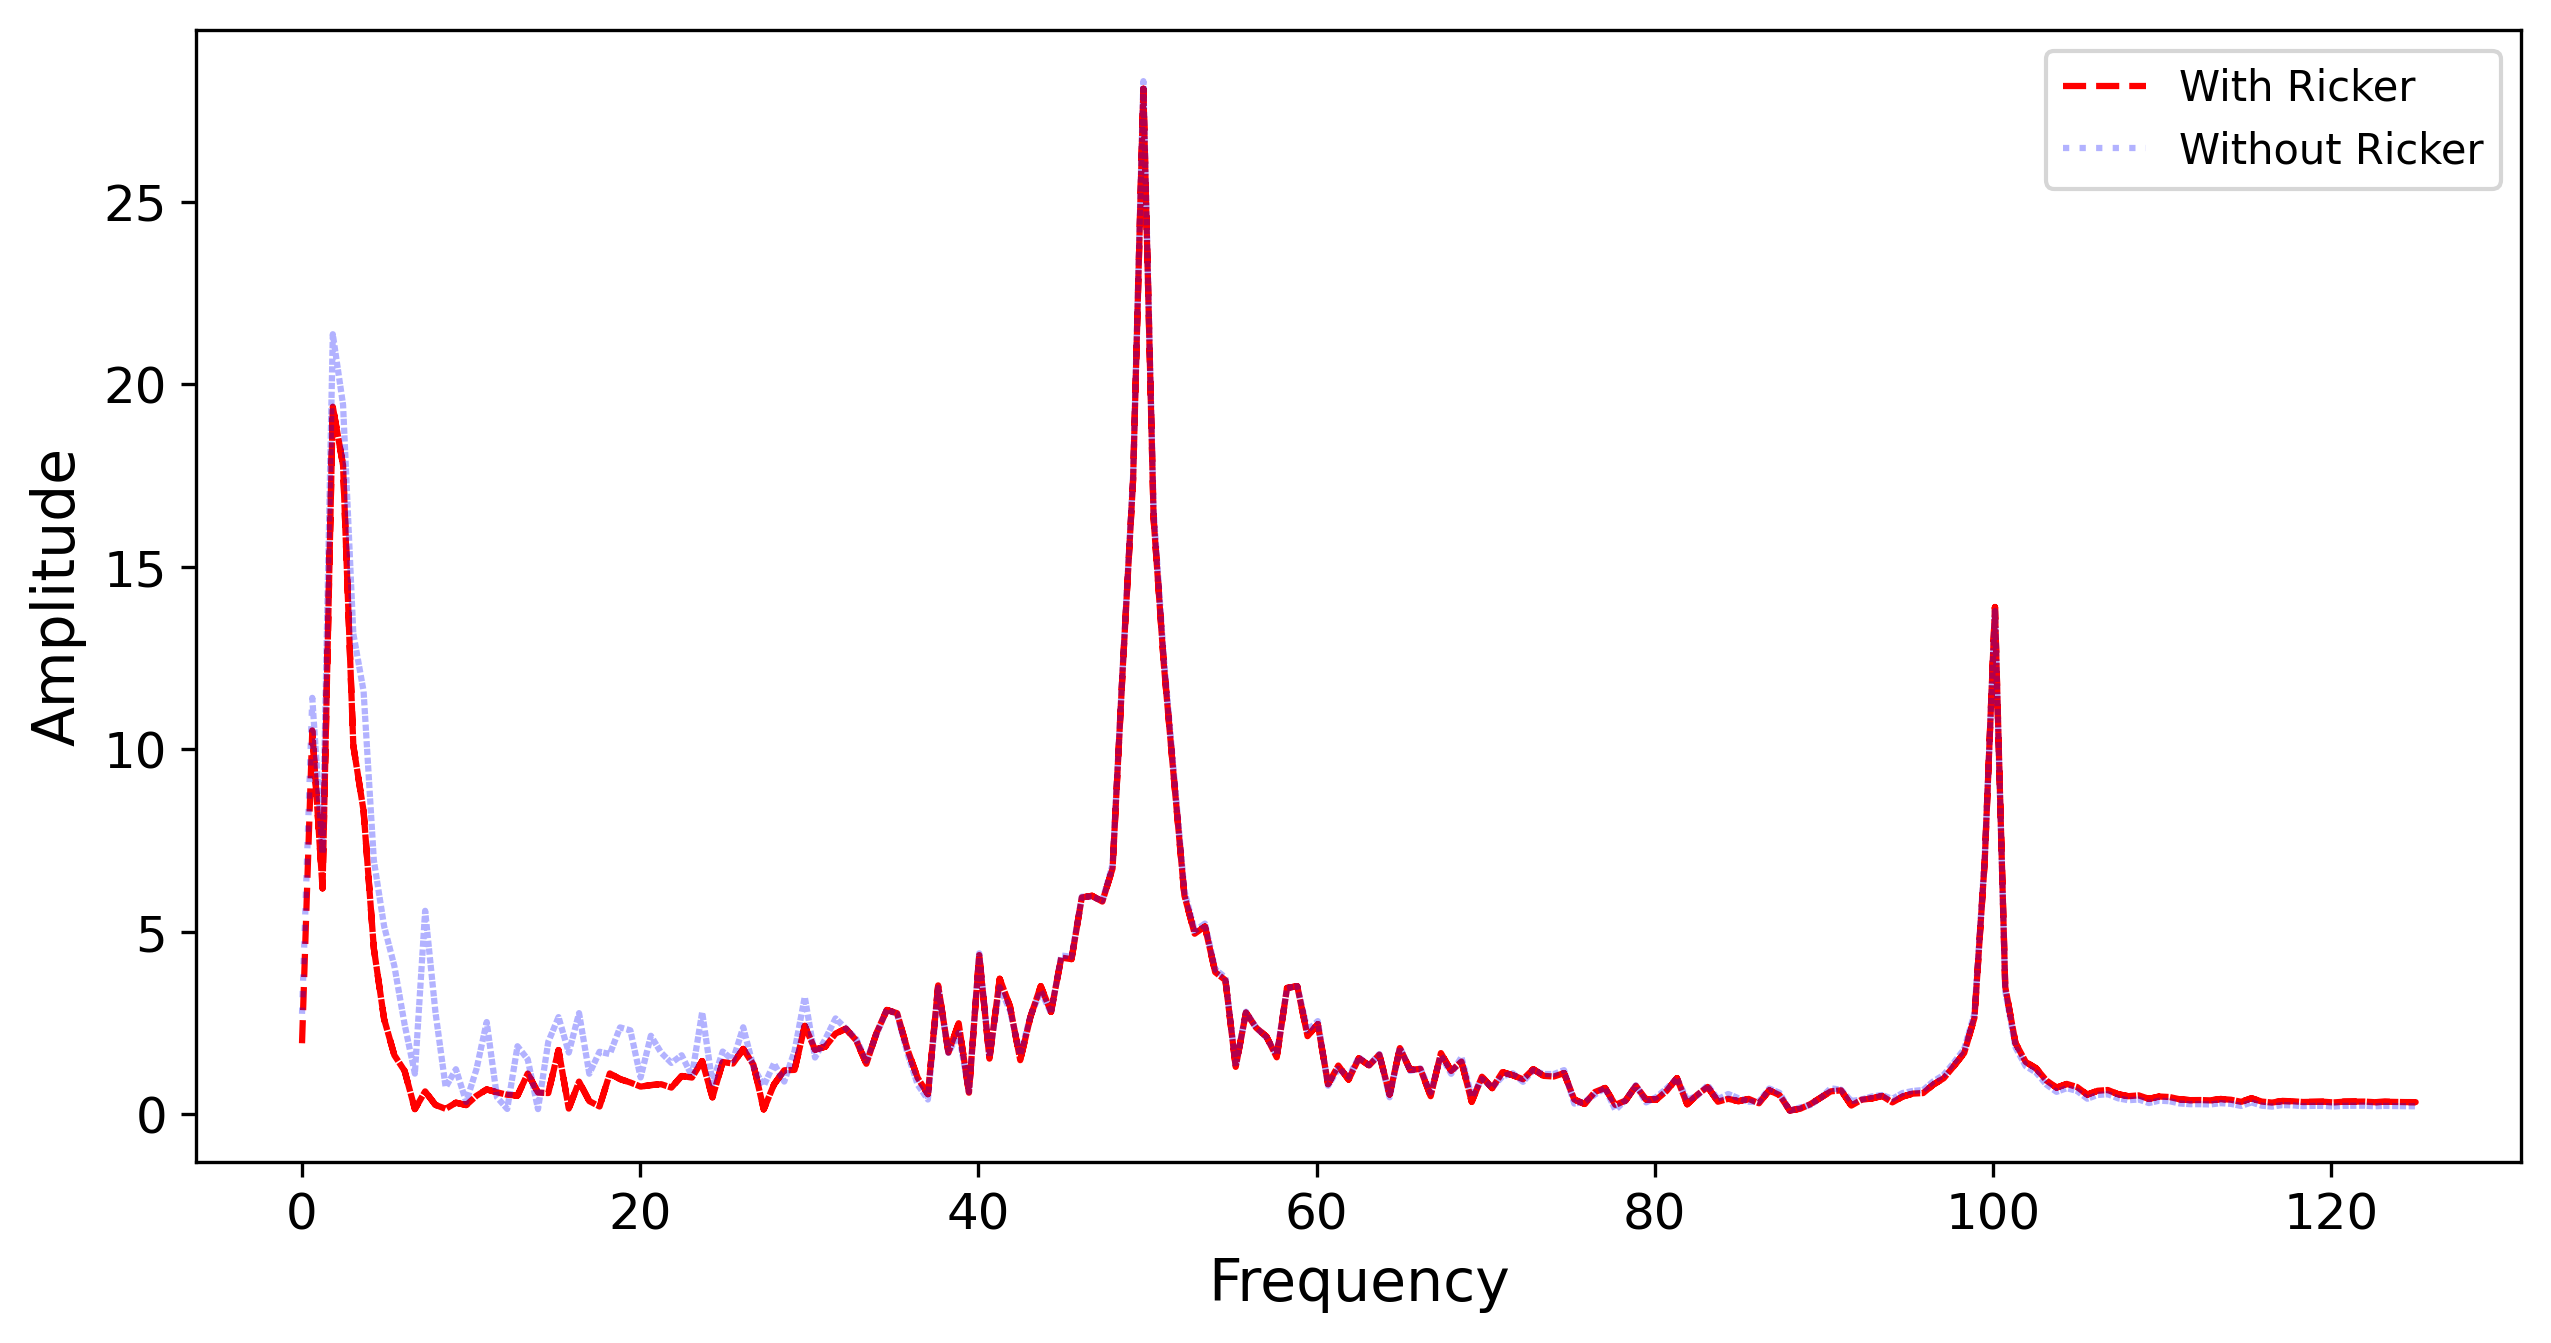

In [30]:

N = len(p[10][2])
y = fft(p[10][2])
x = fftfreq(N,1/250)
plt.plot(abs(x),abs(y),"r--")


N = len(q[10][2])
y = fft(q[10][2])
x = fftfreq(N,1/250)
plt.plot(abs(x),abs(y),"b:",alpha=0.3)
plt.legend(["With Ricker","Without Ricker"])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
# save_fig("fft with and without")
plt.show()

# DATA PROCESSING PIPELINE

### FEATURE EXTRACTION --> LENGTH NORMALIZATION --> DATA SCALING --> DIMENSION REDUCTION

### FEATURE EXTRACTION

In [31]:
class EMG(object):
    """
    preprocessing and feature extraction class for EMG data
    X = List of all instances of input data
    x = an instance of the input data 
    Y = List of all instances of input labels
    y = an instance of the input label
    
    average length of a word utterance: ( 600ms(100 wpm) + 480ms (130 wpm) + 360ms (160 wpm) ) / 3 =  480ms
    """
    
    def __init__(self, SR,FRAME_SIZE,FRAME_SHIFT,MODE):
        """Set the variables """
        self.SR = SR
        self.FRAME_SIZE = FRAME_SIZE
        self.FRAME_SHIFT = FRAME_SHIFT
        self.MODE = MODE
        self.pickle_name = "X_"+MODE+"(features).pickle"
    

    def DNPA(self,seg):
        """Double Nine Point Average"""
        w = []
        for i in range(len(seg)):
            a = i - 4
            b = i + 4
            a = a if a>=0 else 0
            b = b if b<len(seg) else len(seg)
            w.append(int(np.sum(seg[a:b])/9))

        v = []
        for i in range(len(seg)):
            a = i - 4
            b = i + 4
            a = a if a>=0 else 0
            b = b if b<len(seg) else len(seg)
            v.append(int(np.sum(w[a:b])/9))

        return v

    
    def ZCR(self,seg):
        """Zero Crossing Rate"""
        pos = seg>0
        npos = ~pos
        return len(((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0])

    
    def HFS(self,seg):
        """High frequency signals"""
        return np.subtract(seg,self.DNPA(seg))

    
    def RHFS(self,seg):
        """Rectified High frequency signals"""
        return abs(self.HFS(seg))

    
    def FBP(self,seg):
        """Frame Based Power"""
        return np.sum(np.power(seg,2))

    
    def feature(self,seg,type="time"):
        """ 
        "time": Features in time domain
        "freq": Features in frequency domain
        "all": Features in both domain
        """
        if type == "time":
            return np.hstack((self.DNPA(seg),self.RHFS(seg),self.HFS(seg),self.ZCR(seg),self.FBP(seg)))
        elif type == "freq":
            return 
        elif type == "all":
            return np.hstack(self.feature(seg,"time"),self.feature(seg,"freq"))

    
    def MFCC(self,seg):
        """Mel Frequency Cepstral Coefficients"""
        mfcc = librosa.feature.mfcc(y=seg,sr=self.SR,n_mfcc=20)
#         return np.mean(mfcc.T,axis=0)
        return mfcc

    
    def STFT(self,seg):
        """Short Time Fourier Transform"""
        stft = librosa.feature.chroma_stft(y=seg,sr=self.SR,n_fft=20)
#         return np.mean(stft.T,axis=0)
        return stft

    
    def segment(self,x):
        """Segmenting the data into frames and sliding them according to the frame shift"""
        f = []
        for channel in range(6):
            for i in range(len(x[0])):
                a = i*self.FRAME_SHIFT
                b = a + self.FRAME_SIZE
                if(b>len(x[0])):
                    break
                seg = x[channel][a:b]
                f.extend(self.feature(seg))
        return f

    def fit(self,X,Y):
        """Extract Features and return the zero padded list of features"""
        if(self.pickle_name in os.listdir() ):
            print("Fetching Pickle file")
            temp_X = pickle.load(open(self.pickle_name,"rb"))
        else:
            temp_X = []
            for x,count in zip(X, tqdm.tqdm(range(len(X)),ncols=100,desc="Extracting Features("+self.MODE+")" ) ):
                temp_X.append(self.segment(x))

            # save all extracted features to a pickle file
            print("Saving features as: ",self.pickle_name)
            pickle.dump(temp_X,open(self.pickle_name,"wb"))
        temp_X = np.array(temp_X)
        print(len(temp_X))
        print(len(Y))
        print(temp_X.shape)
        return self.reduce_dimension(temp_X),self.encode_labels(Y)

    
    def fit_transform(self,X,Y):
        return self.fit(X,Y)

### LENGTH NORMALIZATION (PADDING AND TRIMMING)

In [32]:
# only apply at the end of the pipeline

def pad_trim(X,Y,LENGTH=600,pad_type="mean"):
    """
    LENGTH: length of signal avergaed over all users for all signals under 95 percentile
    LENGTH = (346+447+868+711)/4 = 593 ~ 600 
    """
    new_X = []
    padder = 0
    for SIGNAL,index in zip(X,tqdm.tqdm(range(len(X)),desc="Padding and Trimming: ")):
        if(len(SIGNAL[0])<LENGTH):
#             print(len(SIGNAL[0]),end=" ")
#             padder = int( (LENGTH-len(SIGNAL[0]))/2)
            a = int(np.floor( (LENGTH-len(SIGNAL[0]))/2))
            b = int(np.ceil( (LENGTH-len(SIGNAL[0]))/2))
            d = 0
            e = LENGTH
        else:
            d = (len(SIGNAL[0])//2)-300
            e = (len(SIGNAL[0])//2)+300
        new_X.append((np.pad(SIGNAL,((0,0),(a,b)),mode=pad_type))[:,d:e])
    return new_X,Y

In [33]:
X_mouthed_US_test , Y_mouthed_US_test = pad_trim(X_mouthed_US,Y_mouthed_US)
X_mouthed_SR_test , Y_mouthed_SR_test = pad_trim(X_mouthed_SR,Y_mouthed_SR)
X_mouthed_RL_test , Y_mouthed_RL_test = pad_trim(X_mouthed_RL,Y_mouthed_RL)
X_mouthed_RN_test , Y_mouthed_RN_test = pad_trim(X_mouthed_RN,Y_mouthed_RN)

Padding and Trimming: 100%|█████████▉| 321/322 [00:00<00:00, 3543.63it/s]


In [34]:
print("Samples Length: ",len(X_mouthed_US_test[1][5]),end=" ")
print(len(X_mouthed_SR_test[10][0]),end=" ")
print(len(X_mouthed_RL_test[100][0]),end=" ")
print(len(X_mouthed_RN_test[200][6]))
# print(x[55].shape)
# plt.plot(x[55][0])

# CHECK IF FUNCTION HAS CAUSED ANY VARIATION IN LENGTH 
print("Total Samples: ",len(X_mouthed_US_test),end=" ")
print(len(X_mouthed_SR_test),end=" ")
print(len(X_mouthed_RL_test),end=" ")
print(len(X_mouthed_RN_test))

Samples Length:  600 600 600 600
Total Samples:  1758 246 159 322


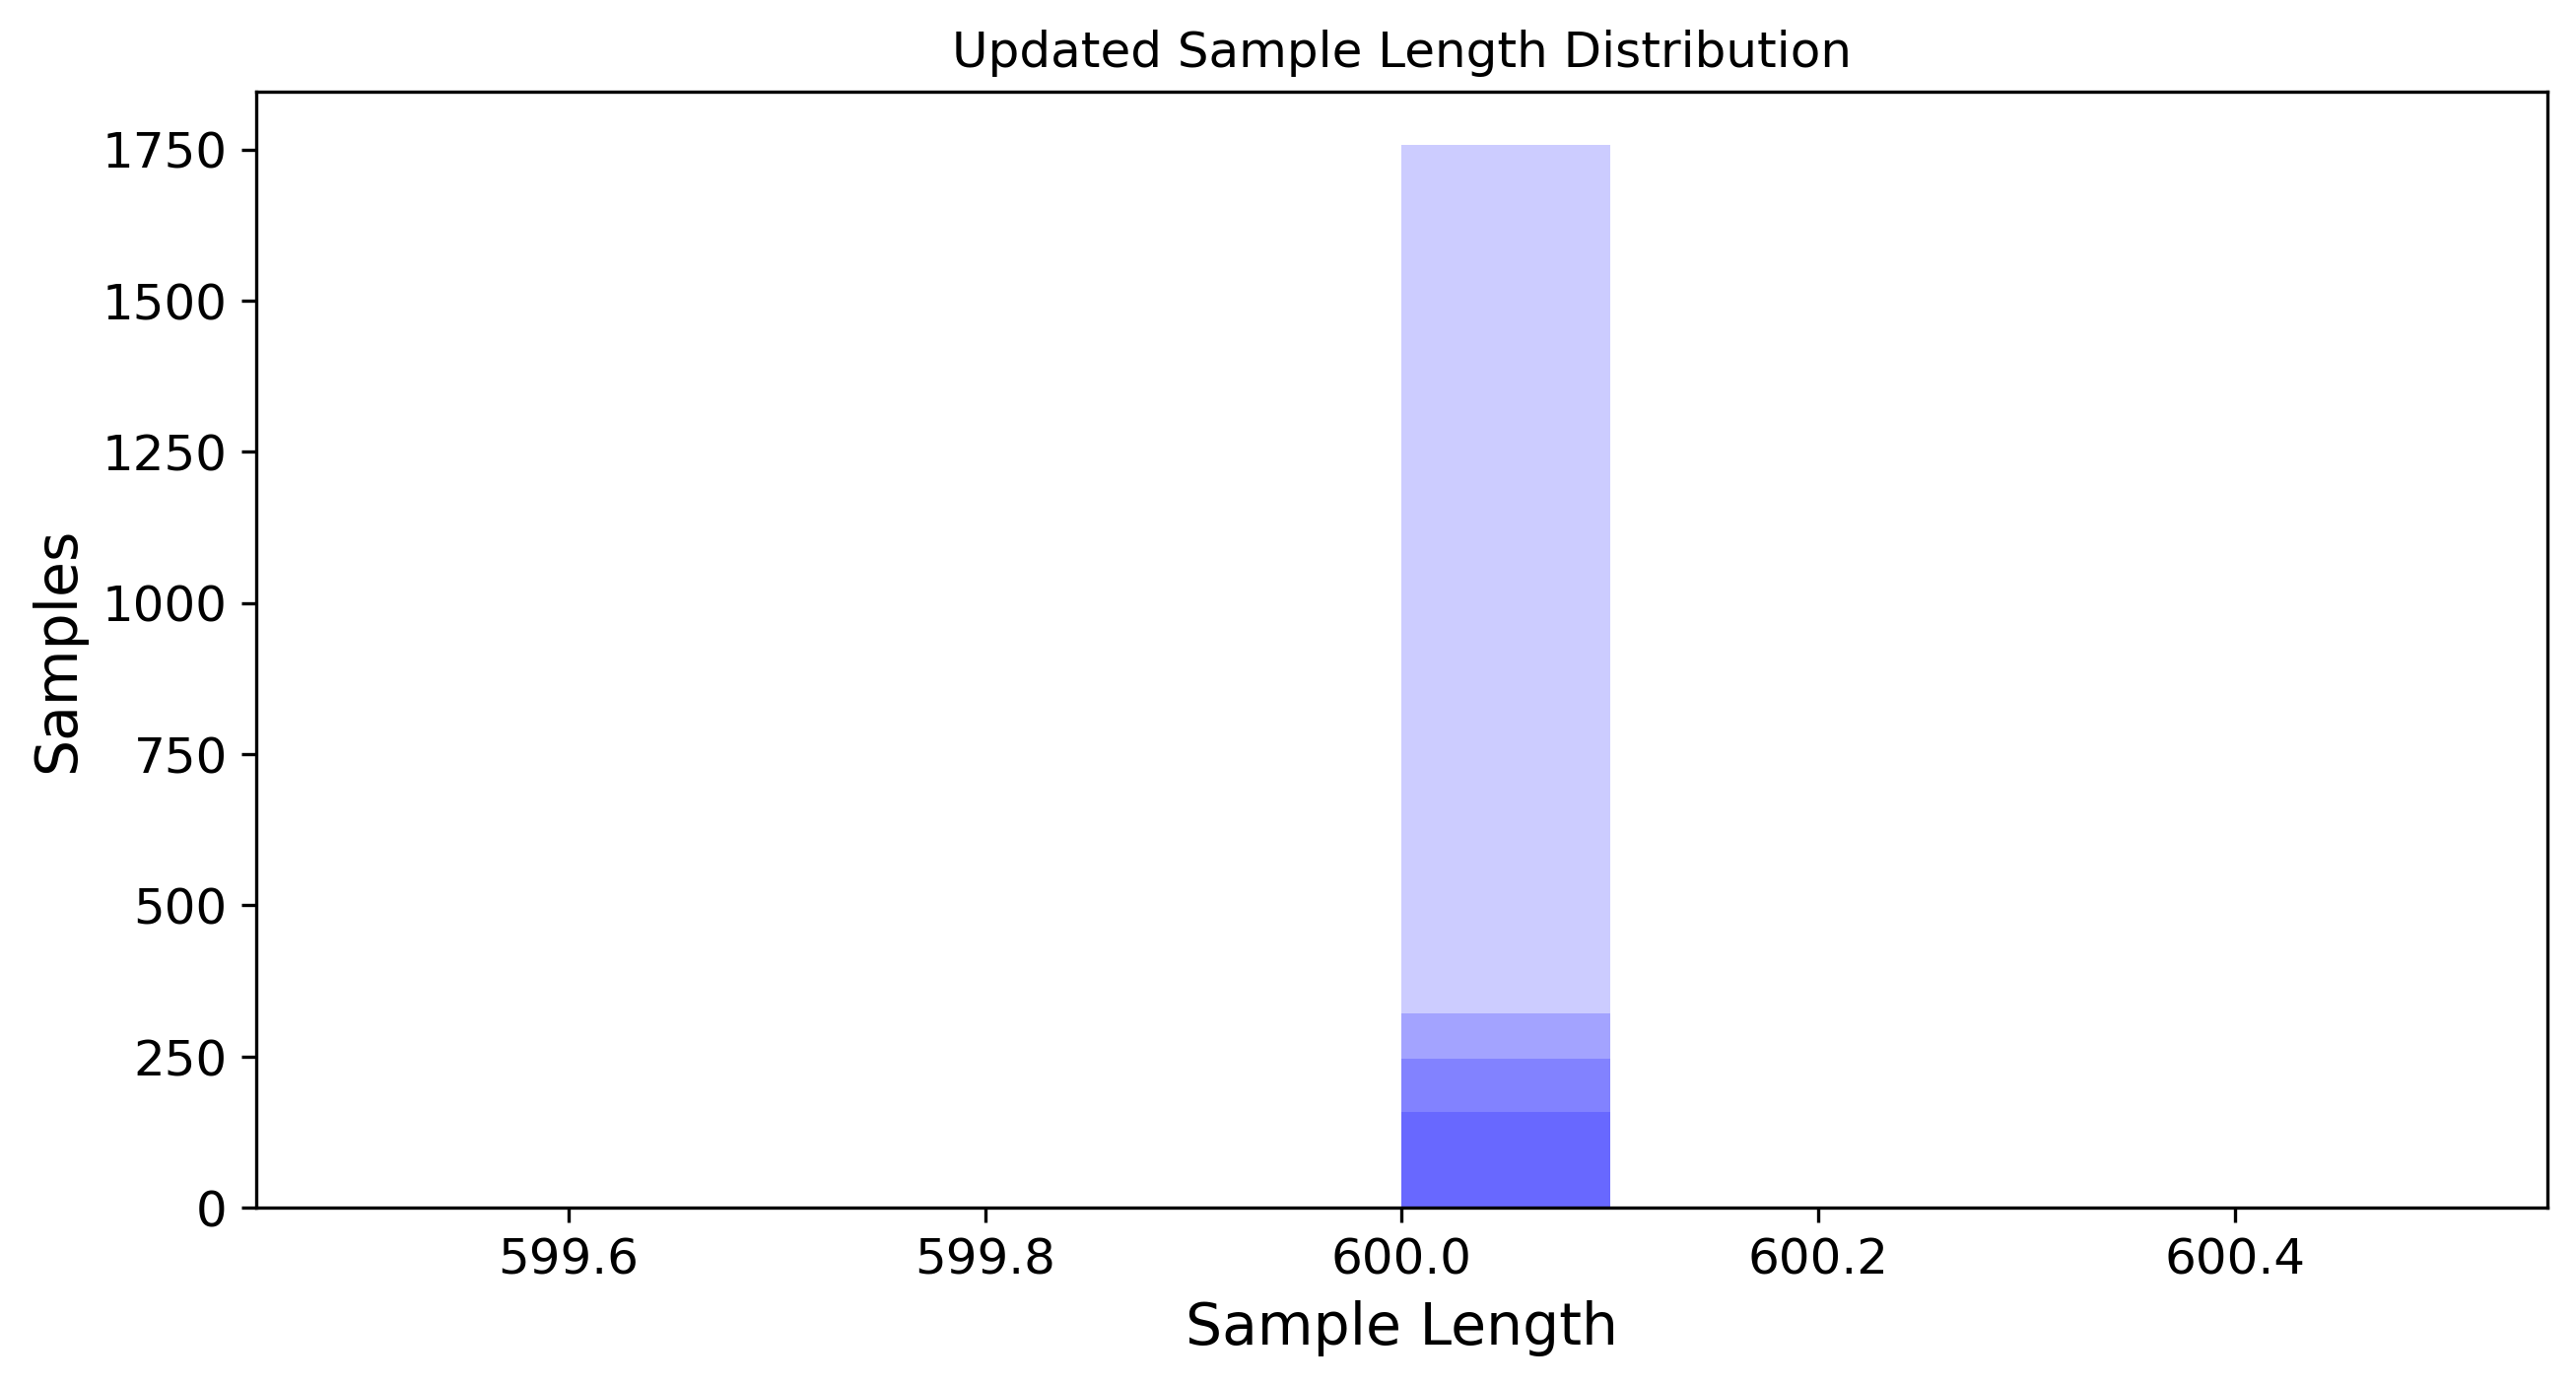

In [35]:
plt.title("Updated Sample Length Distribution")
plt.xlabel("Sample Length")
plt.ylabel("Samples")
plt.hist([len((x[0])) for x in X_mouthed_US_test],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_SR_test],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_RL_test],color="b",alpha=0.2)
plt.hist([len((x[0])) for x in X_mouthed_RN_test],color="b",alpha=0.2)
# save_fig("sample length distribution")
plt.show()

In [36]:
def signal_pipeline(X,Y):
    """
    SIGNAL SMOOTHING --> SIGNAL NORMALIZATION --> DIGITAL FILTERING
    """
    print("Performing Signal Processing")
    new_X,new_Y = smoother(X,Y)
    new_X,new_Y = apply_filter(new_X,new_Y,RICKER=True)
    return new_X,new_Y

In [41]:
def data_pipeline(X,Y):
    """
    FEATURE EXTRACTION --> LENGTH NORMALIZATION --> DATA SCALING --> DIMENSION REDUCTION
    """
    new_X, new_Y = pad_trim(X,Y)
    return np.array(new_X),np.array(new_Y)

In [42]:
# XXX ,YYY = signal_pipeline(X_mouthed_RL,Y_mouthed_RL)
# XXX ,YYY = signal_pipeline(X,Y)
# XXXX,YYYY = data_pipeline(X,Y)

In [43]:
X ,Y = signal_pipeline(X_mouthed_US,Y_mouthed_US)
X ,Y = data_pipeline(X,Y)

Smoothing Signal:   0%|          | 6/1758 [00:00<00:35, 49.23it/s]

Performing Signal Processing


Padding and Trimming: 100%|█████████▉| 1757/1758 [00:00<00:00, 5151.19it/s]


In [44]:
X.shape,Y.shape

((1758, 8, 600), (1758,))

In [50]:
# reshaping X (changing channel columns to rows) 
X_temp = np.array(list(map(np.transpose,X)))
# X_mouthed_SR = list(map(np.transpose,X_mouthed_SR))
# X_mouthed_RL = list(map(np.transpose,X_mouthed_RL))
# X_mouthed_RN = list(map(np.transpose,X_mouthed_RN))

# X_mentally_US = list(map(np.transpose,X_mentally_US))
# X_mentally_SR = list(map(np.transpose,X_mentally_SR))
# X_mentally_RL = list(map(np.transpose,X_mentally_RL))
# X_mentally_RN = list(map(np.transpose,X_mentally_RN))


In [77]:
X_temp.shape ,Y.shape

((1758, 600, 8), (1758,))

### COMBINING ALL DATA FROM ALL 4 USERS

In [ ]:
X = X_mouthed_US + X_mouthed_SR + X_mouthed_RL + X_mouthed_RN 
Y = Y_mouthed_US + Y_mouthed_SR + Y_mouthed_RL + Y_mouthed_RN
print("Total Data (X):",len(X))
print("Total Labels (Y):",len(Y))

Raw feature shape:  (1758, 4800)


In [79]:
from copy import deepcopy

X_CNN = deepcopy(X_temp)

print(X_CNN.shape)

(1758, 600, 8)


### DIMENSION REDUCTION (ICA)

In [ ]:
reducer = FastICA(n_components=100,random_state=42)
X = reducer.fit_transform(X)

In [ ]:
print("Reduced feature shape",np.array(X).shape)

In [ ]:
from sklearn.decomposition import PCA

reducer = PCA(n_components=100,random_state=42)
X = reducer.fit_transform(X)

### LABEL ENCODING

In [80]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y_1hot = tf.keras.utils.to_categorical(Y, num_classes = 10)
print(encoder.classes_)
print("Encoded labels (normal): \n",Y[0:5])
print("Encoded labels (ONE-HOT): \n",Y_1hot[0:5])

[0 1 2 3 4 5 6 7 8 9]
Encoded labels (normal): 
 [1 1 1 1 1]
Encoded labels (ONE-HOT): 
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


### TRAIN TEST SPLIT

In [81]:
def train_test_split(X,Y):
    split = StratifiedShuffleSplit(n_splits=1, test_size =0.1, random_state=42)
    train_id, test_id = next(split.split(X,Y))
    return np.array([X[n] for n in train_id]), np.array([Y[n] for n in train_id]), np.array([X[n] for n in test_id]),np.array([Y[n] for n in test_id])

In [83]:
# X_train,Y_train,X_test,Y_test = train_test_split(X,Y)

In [90]:
print("Train Set Shape: ",X_train.shape)
print("Test Set Shape: ",X_test.shape)

print("Train Set Shape: ",Y_train.shape)
print("Test Set Shape: ",Y_test.shape)


Train Set Shape:  (1582, 600, 8)
Test Set Shape:  (176, 600, 8)
Train Set Shape:  (1582,)
Test Set Shape:  (176,)


## MODEL DEVELOPMENT

### MLP MODEL

### FLATENNING THE CHANNEL DATA TO A SINGLE ROW VECTOR (FOR MLP)

In [113]:
# X_MLP = np.array([x.flatten() for x in X])
# print("Raw feature shape: ",X.shape)

X_MLP = np.array([x.flatten() for x in X_temp])
print("Raw feature shape: ",X_MLP.shape)

Raw feature shape:  (1758, 4800)


In [115]:
X_train,Y_train,X_test,Y_test = train_test_split(X_MLP,Y)

print("Train Set Shape of X: ",X_train.shape)
print("Test Set Shape of X: ",X_test.shape)

print("Train Set Shape of Y: ",Y_train.shape)
print("Test Set Shape of Y: ",Y_test.shape)

Train Set Shape of X:  (1582, 4800)
Test Set Shape of X:  (176, 4800)
Train Set Shape of Y:  (1582,)
Test Set Shape of Y:  (176,)


In [63]:
MLP_model = keras.Sequential()
MLP_model.add(keras.layers.Dense(units=1000,activation="relu",input_shape=X_train[0].shape))
MLP_model.add(keras.layers.Dropout(0.5))
MLP_model.add(keras.layers.Dense(32,activation="relu"))
MLP_model.add(keras.layers.Dropout(0.5))
MLP_model.add(keras.layers.Dense(10,activation="softmax"))
print(MLP_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              4801000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 4,833,362
Trainable params: 4,833,362
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
optimizer=keras.optimizers.Adam()
MLP_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [65]:
history = MLP_model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test),verbose=1)

Epoch 1/20
50/50 [==============================] - 2s 37ms/step - loss: 1.9320 - accuracy: 0.3375 - val_loss: 1.3669 - val_accuracy: 0.5398
Epoch 2/20
50/50 [==============================] - 2s 32ms/step - loss: 1.5653 - accuracy: 0.4671 - val_loss: 1.1779 - val_accuracy: 0.6932
Epoch 3/20
50/50 [==============================] - 2s 38ms/step - loss: 1.4497 - accuracy: 0.5215 - val_loss: 1.0268 - val_accuracy: 0.6420
Epoch 4/20
50/50 [==============================] - 2s 33ms/step - loss: 1.3030 - accuracy: 0.5493 - val_loss: 0.9547 - val_accuracy: 0.7500
Epoch 5/20
50/50 [==============================] - 2s 34ms/step - loss: 1.1501 - accuracy: 0.6024 - val_loss: 0.7680 - val_accuracy: 0.7727
Epoch 6/20
50/50 [==============================] - 2s 33ms/step - loss: 1.0987 - accuracy: 0.6327 - val_loss: 0.7660 - val_accuracy: 0.7500
Epoch 7/20
50/50 [==============================] - 2s 33ms/step - loss: 0.9769 - accuracy: 0.6606 - val_loss: 0.6293 - val_accuracy: 0.7784
Epoch 8/20
50

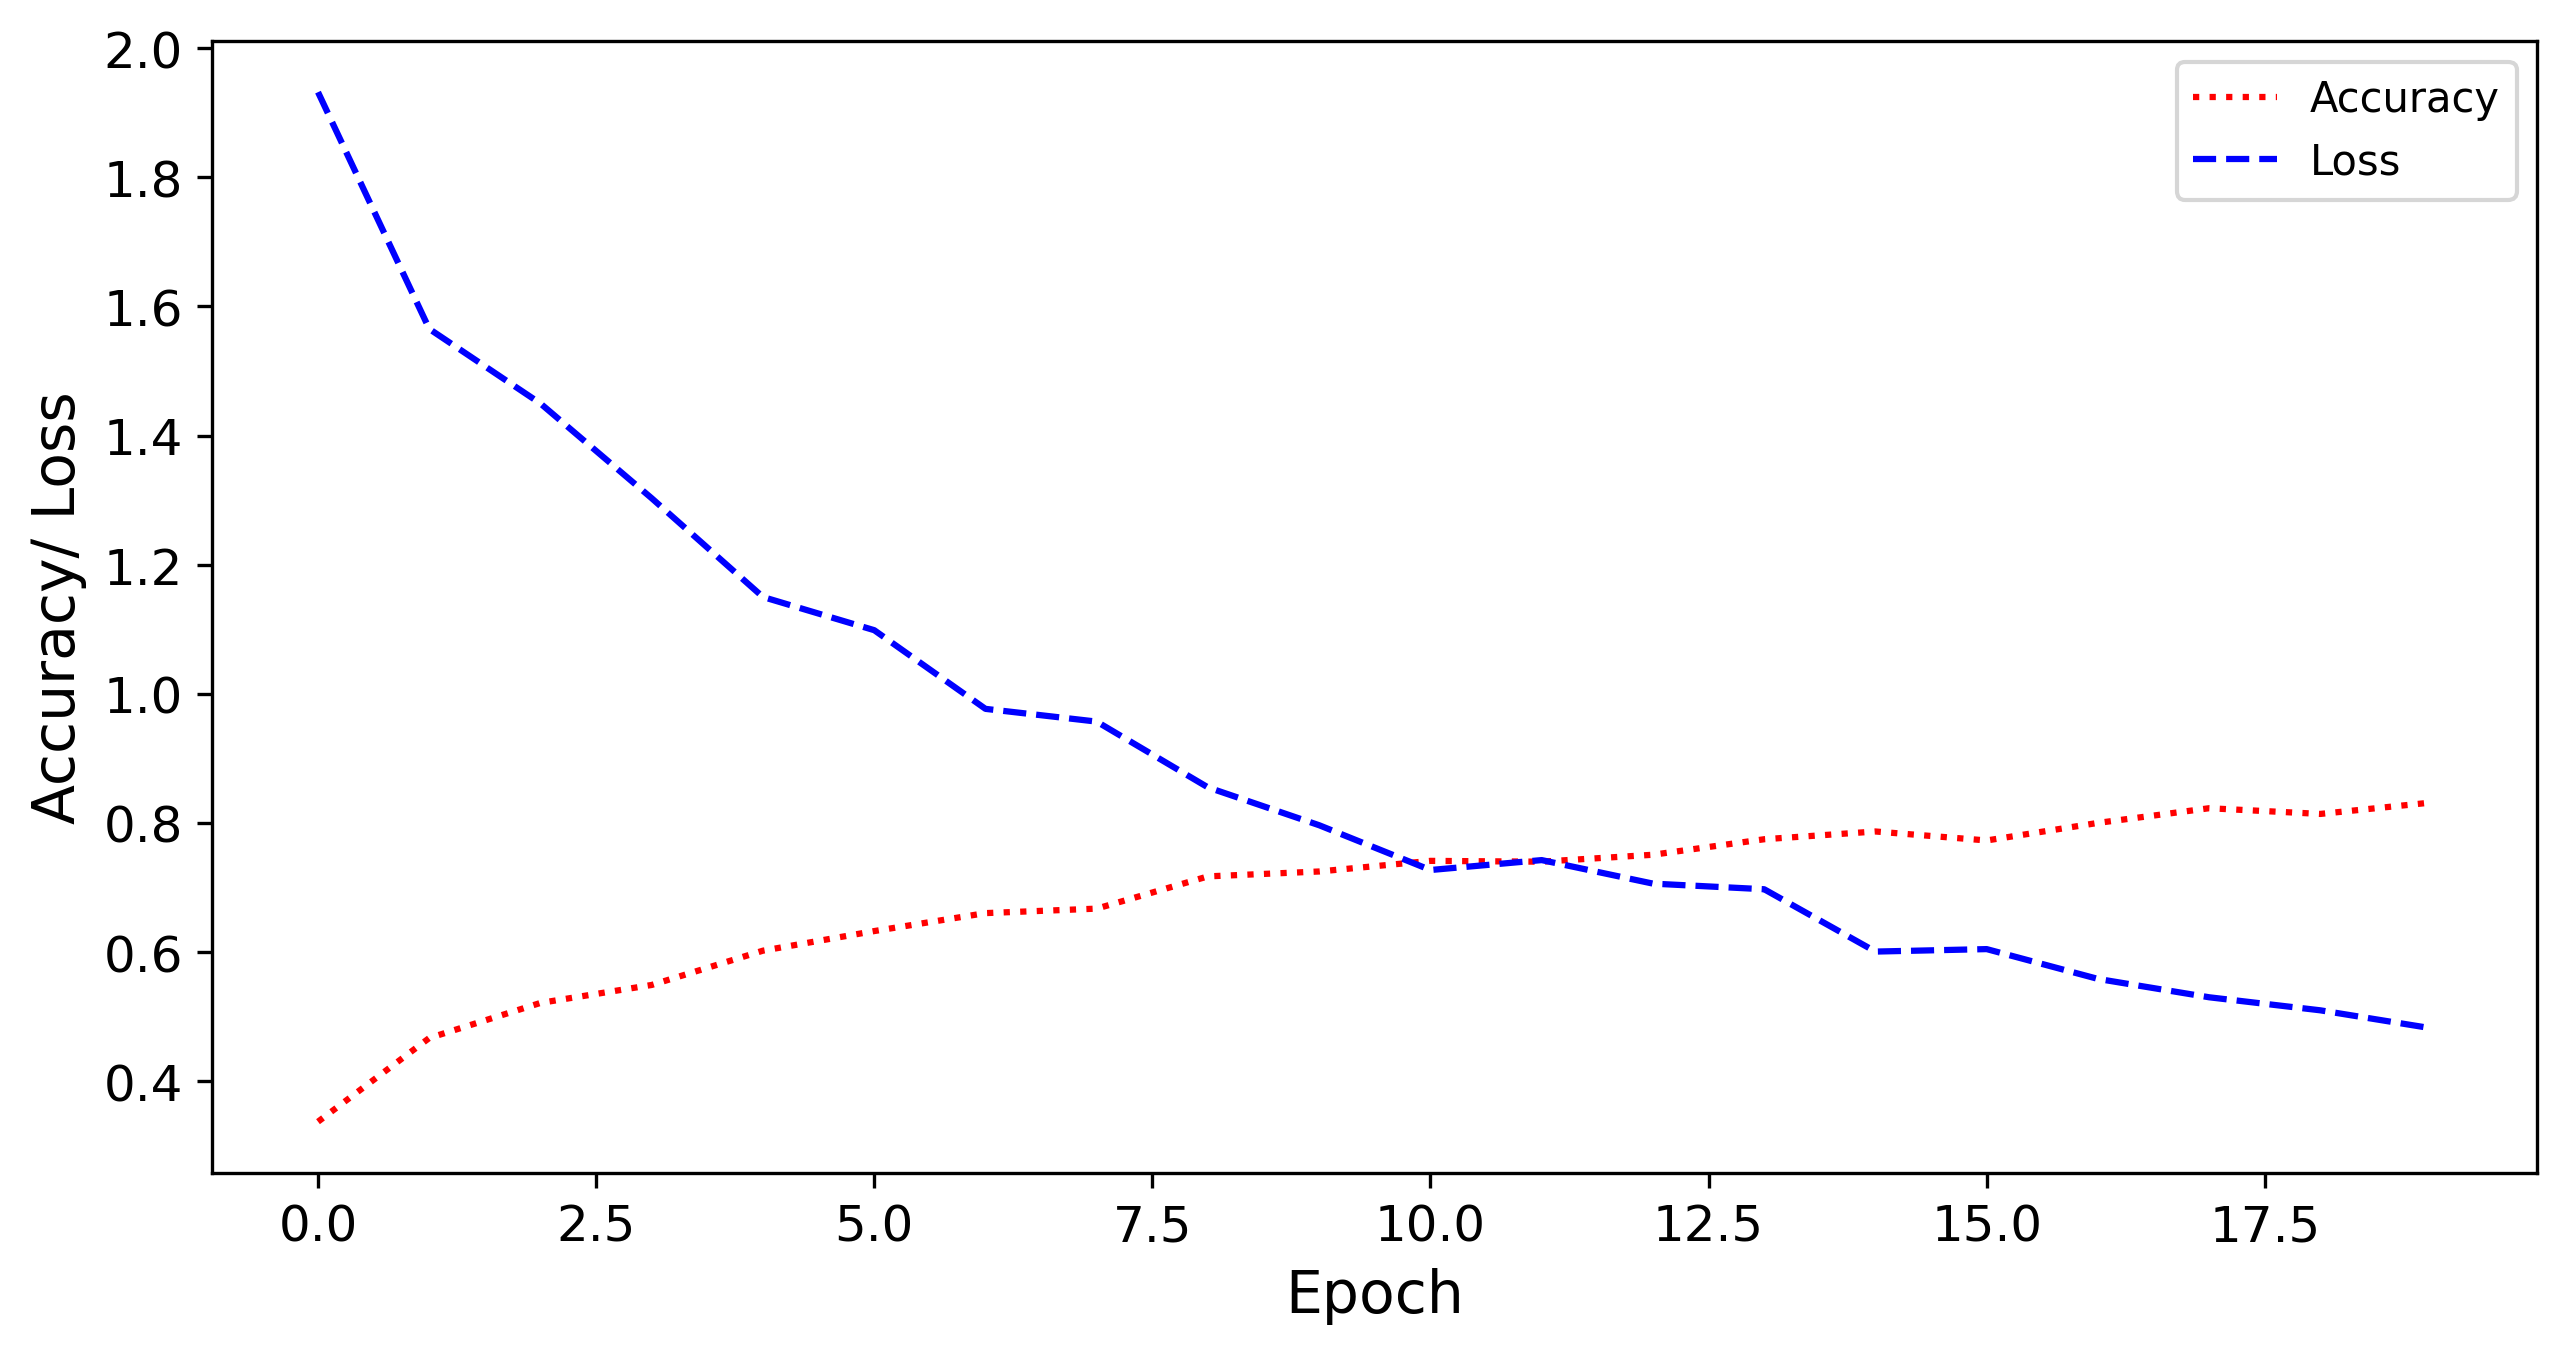

In [66]:
plt.plot(history.history["accuracy"],"r:")
plt.plot(history.history["loss"],"b--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/ Loss")
plt.legend(["Accuracy","Loss"])
# save_fig("ACC_LOSS_US_FIltered")

In [68]:
MLP_prediction = np.array(list(map(np.argmax,MLP_model.predict(X_test))))
print(type(MLP_prediction))

<class 'numpy.ndarray'>


In [118]:
print("ACTUAL:    ",Y_test[:30])
print("PREDICTED: ",MLP_prediction[:30])

ACTUAL:     [7 9 1 7 6 9 2 5 4 4 7 0 9 4 7 4 7 7 6 7 0 0 7 4 6 6 2 8 5 1]
PREDICTED:  [3 9 1 7 6 2 2 5 4 4 7 0 9 4 7 4 4 7 0 7 0 0 7 4 6 6 2 8 0 1]


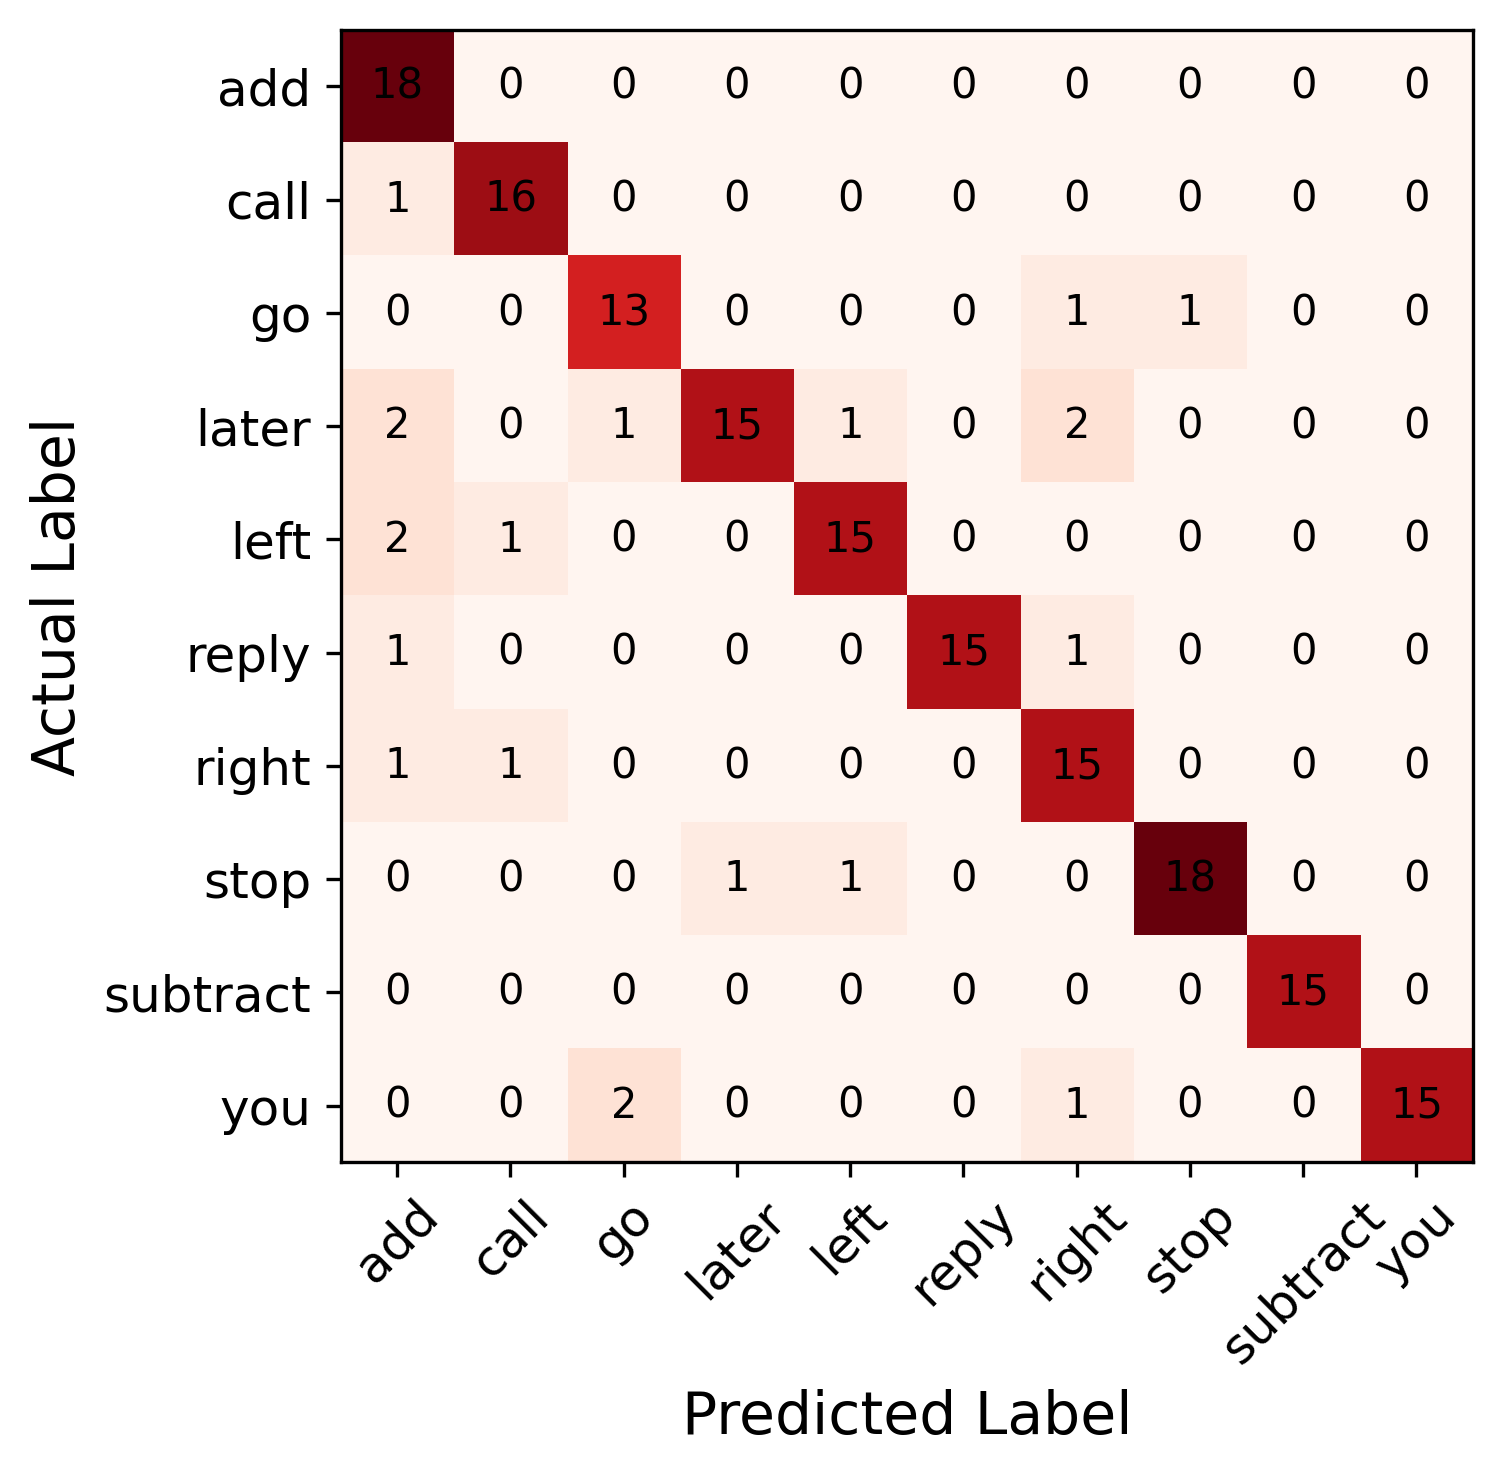

In [70]:
cm =confusion_matrix(Y_test,MLP_prediction)
plt.xticks(range(len(WORDS)), WORDS, rotation = 45)
plt.yticks(range(len(WORDS)), WORDS)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.imshow(cm,cmap=plt.cm.Reds)
for i in range(10):
    for j in range(10):
        plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center')
# save_fig("cm_mouthed_US_Filtered")
plt.show()


### CNN MODEL

In [119]:
X_train,Y_train,X_test,Y_test = train_test_split(X_CNN,Y)
print("Train Set Shape: ",X_train.shape)
print("Test Set Shape: ",X_test.shape)

print("Train Set Shape: ",Y_train.shape)
print("Test Set Shape: ",Y_test.shape)

Train Set Shape:  (1582, 600, 8)
Test Set Shape:  (176, 600, 8)
Train Set Shape:  (1582,)
Test Set Shape:  (176,)


In [120]:
Y_train = (Y_train.reshape(-1,len(Y_train))).T
Y_test = (Y_test.reshape(-1,len(Y_test))).T

print("Train Set Shape: ",X_train.shape)
print("Test Set Shape: ",X_test.shape)

print("Train Set Shape: ",Y_train.shape)
print("Test Set Shape: ",Y_test.shape)

Train Set Shape:  (1582, 600, 8)
Test Set Shape:  (176, 600, 8)
Train Set Shape:  (1582, 1)
Test Set Shape:  (176, 1)


In [121]:
#     Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = 10)
#     Y_test = tf.keras.utils.to_categorical(Y_test, num_classes = 10)
CNN_model = keras.Sequential()
CNN_model.add(keras.layers.Conv1D(100, kernel_size = 12, input_shape =(n_timesteps,n_features), activation = "relu"))
# 	CNN_model.add(keras.layers.Conv1D(100, kernel_size = 12, input_shape = X_train.shape[1:], activation = "relu"))
CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
CNN_model.add(keras.layers.Conv1D(100,kernel_size=6,activation="relu"))
CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
CNN_model.add(keras.layers.Flatten())
CNN_model.add(keras.layers.Dense(100,activation="relu"))
CNN_model.add(keras.layers.Dense(10,activation="softmax"))

opt = keras.optimizers.Adam(lr = 0.0001)

CNN_model.compile(optimizer = opt, loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
print(CNN_model.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 589, 100)          9700      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 294, 100)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 289, 100)          60100     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 144, 100)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               1440100   
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

In [122]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

In [123]:
history = CNN_model.fit(X_train, Y_train, epochs = 5, batch_size = 50, validation_data =(X_test, Y_test) ,verbose = 1)


Epoch 1/5
32/32 [==============================] - 5s 159ms/step - loss: 1.9416 - accuracy: 0.4475 - val_loss: 1.4220 - val_accuracy: 0.6250
Epoch 2/5
32/32 [==============================] - 5s 161ms/step - loss: 1.0660 - accuracy: 0.6972 - val_loss: 0.8766 - val_accuracy: 0.7045
Epoch 3/5
32/32 [==============================] - 6s 188ms/step - loss: 0.7138 - accuracy: 0.7895 - val_loss: 0.6742 - val_accuracy: 0.7784
Epoch 4/5
32/32 [==============================] - 6s 189ms/step - loss: 0.5520 - accuracy: 0.8489 - val_loss: 0.5863 - val_accuracy: 0.8068
Epoch 5/5
32/32 [==============================] - 5s 171ms/step - loss: 0.4533 - accuracy: 0.8774 - val_loss: 0.5513 - val_accuracy: 0.8409


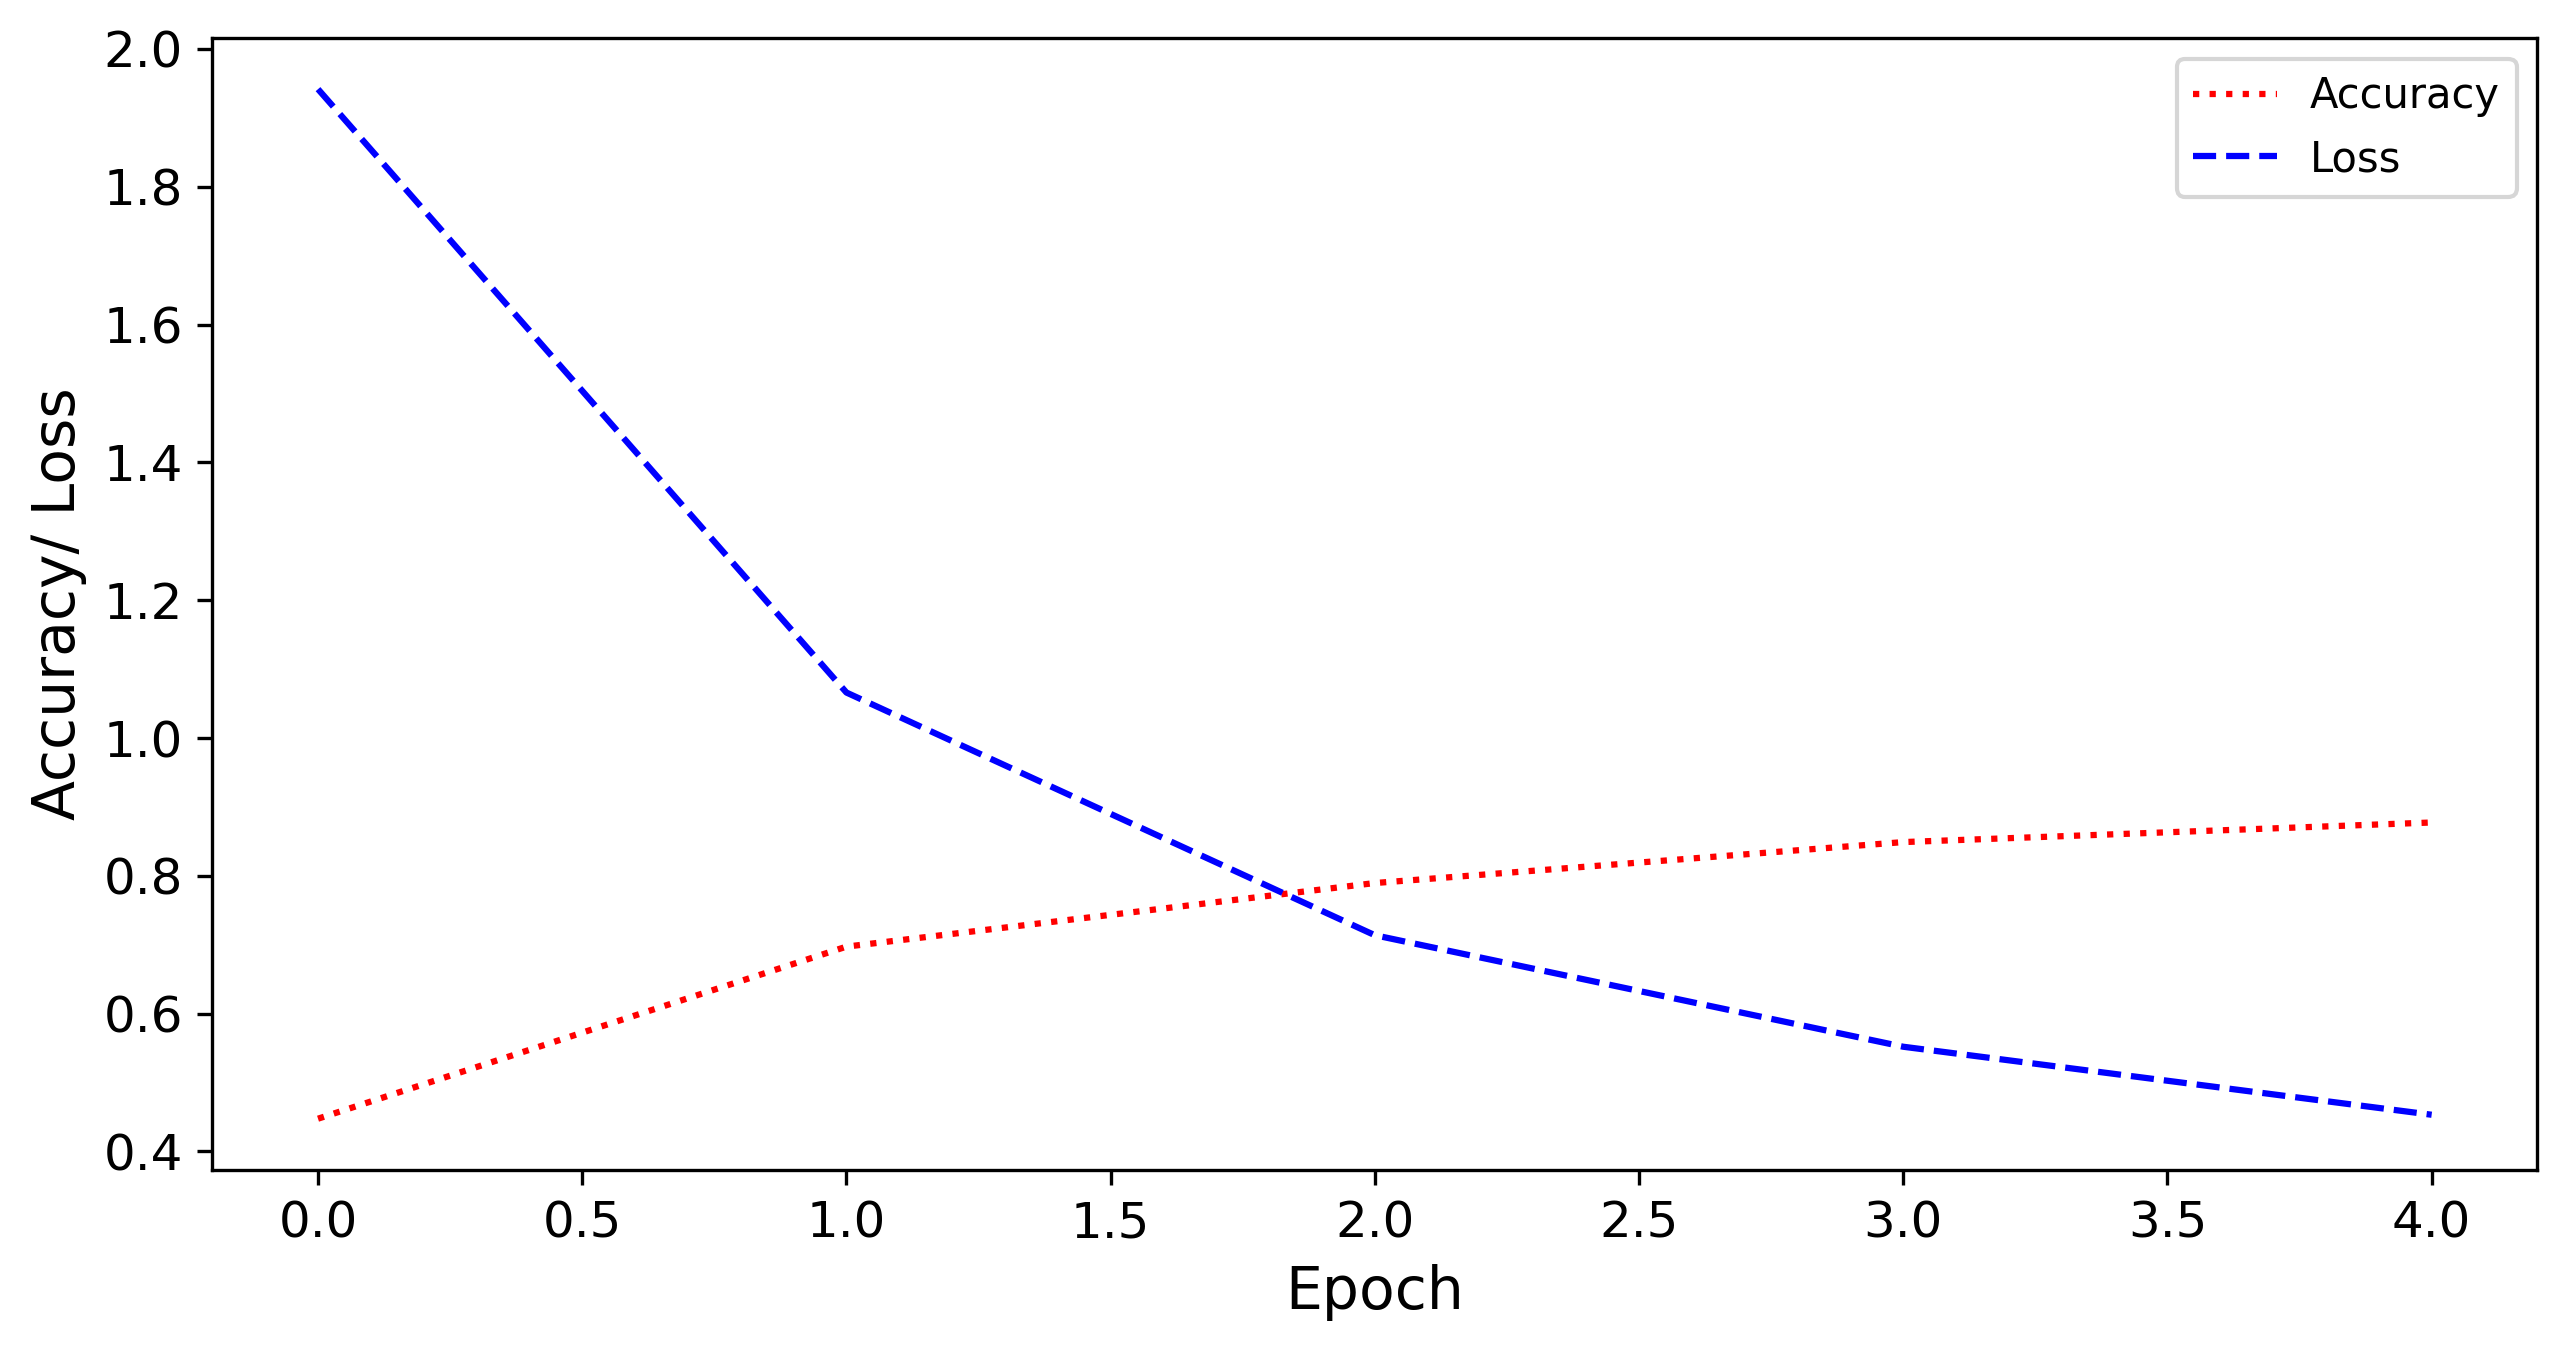

In [124]:
plt.plot(history.history["accuracy"],"r:")
plt.plot(history.history["loss"],"b--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/ Loss")
plt.legend(["Accuracy","Loss"])
# save_fig("ACC_LOSS_US_FIltered")

In [130]:
CNN_prediction = np.array(list(map(np.argmax,CNN_model.predict(X_test))))
print(type(CNN_prediction))
print("ACTUAL:    ",(Y_test[:30]).flatten())
print("PREDICTED: ",CNN_prediction[:30])

<class 'numpy.ndarray'>
ACTUAL:     [7 9 1 7 6 9 2 5 4 4 7 0 9 4 7 4 7 7 6 7 0 0 7 4 6 6 2 8 5 1]
PREDICTED:  [7 9 1 7 6 3 2 5 4 4 7 0 9 4 7 4 4 7 6 7 0 0 7 4 6 8 2 8 0 1]


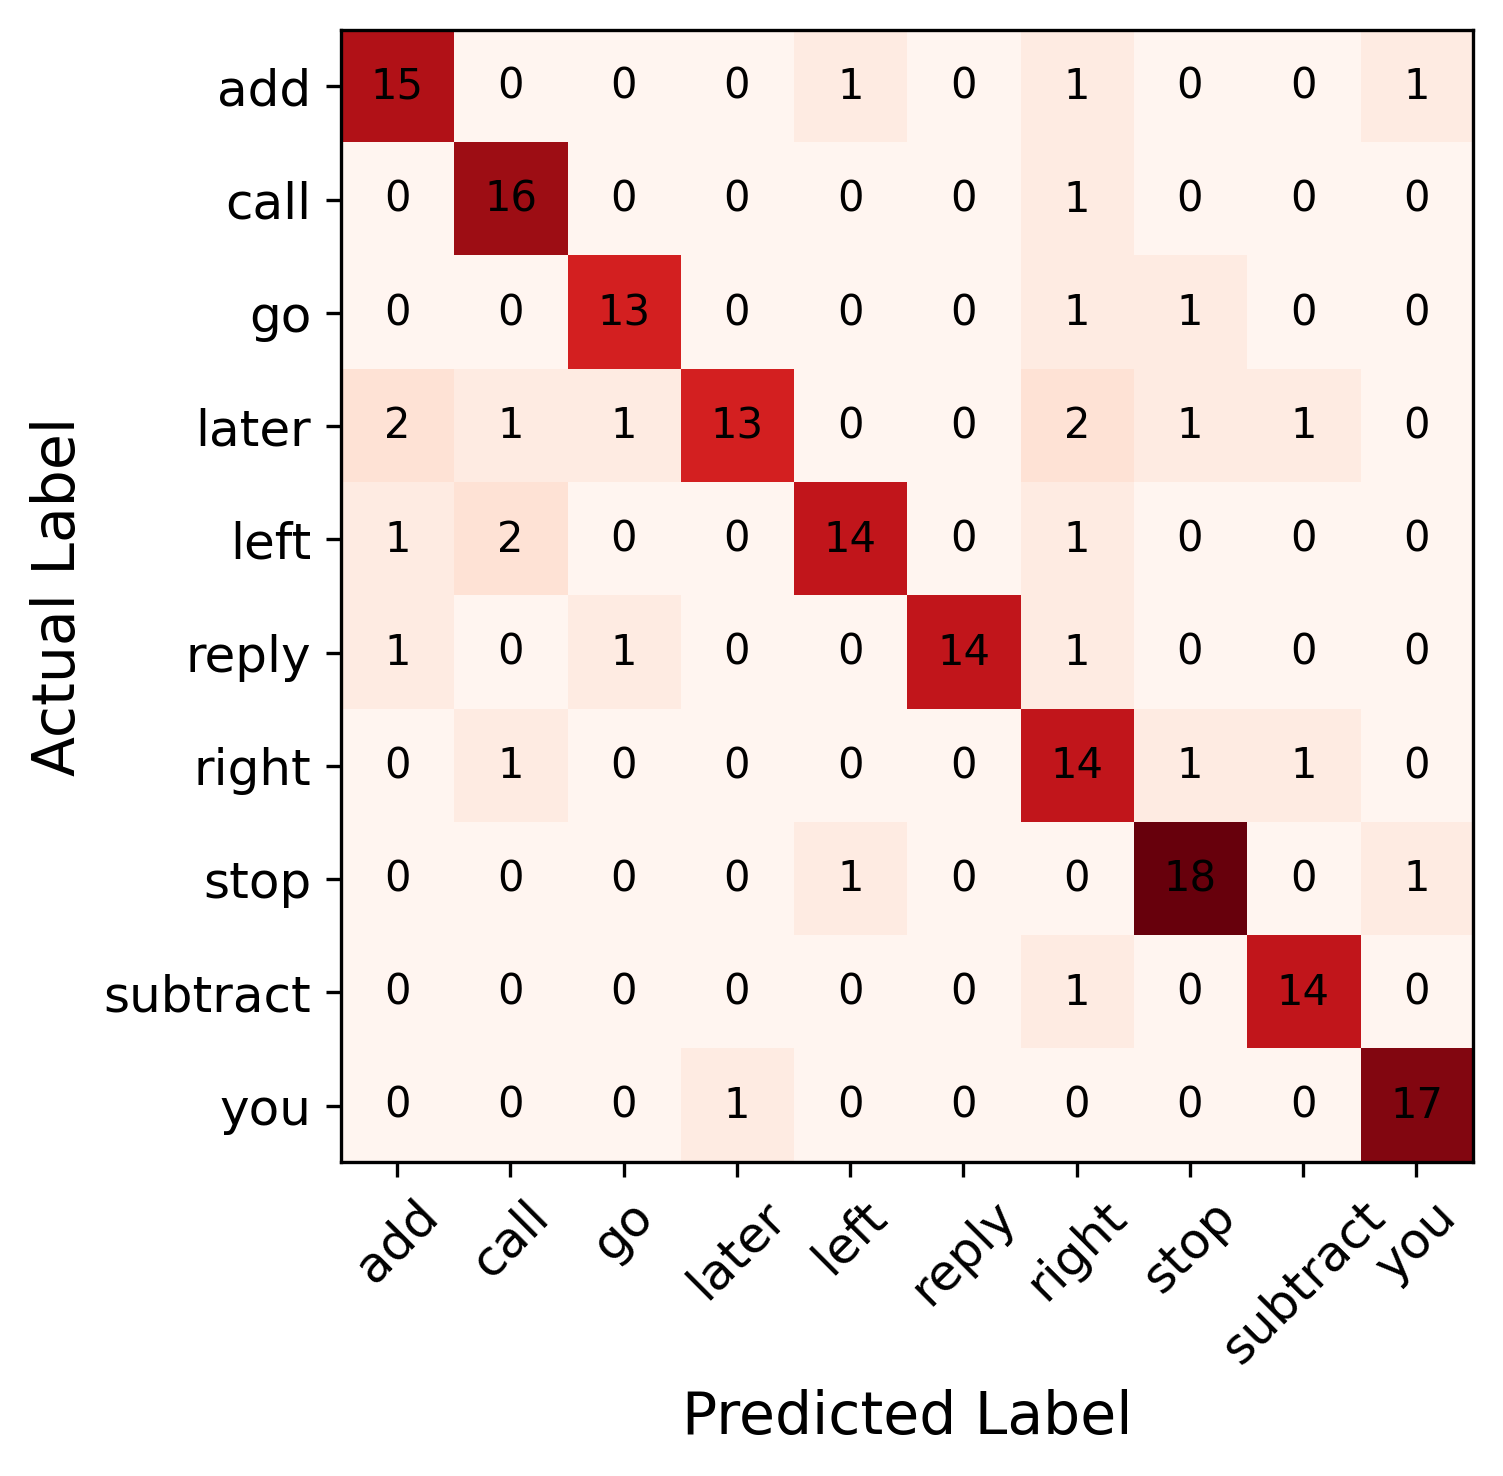

In [131]:
cm =confusion_matrix(Y_test,CNN_prediction)
plt.xticks(range(len(WORDS)), WORDS, rotation = 45)
plt.yticks(range(len(WORDS)), WORDS)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.imshow(cm,cmap=plt.cm.Reds)
for i in range(10):
    for j in range(10):
        plt.text(j,i, cm[i][j],horizontalalignment='center',verticalalignment='center')
# save_fig("cm_mouthed_US_Filtered")
plt.show()
